# Análise do Teste A/B

### 1) Configuração do Sistema

In [ ]:
# Bibliotecas padrão
import os
import builtins

# Bibliotecas de análise e visualização
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import ttest_ind

# Geopandas
import geopandas as gpd

# IPython (uso em notebooks)
from IPython import get_ipython

# PySpark e funções
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import DateType

# Funções específicas do PySpark (importadas diretamente para facilitar uso direto)
from pyspark.sql.functions import (
    col, when, lower, upper, year, month, to_timestamp,
    sum as spark_sum, avg, count, countDistinct, max as spark_max,
    floor, hour, dayofweek, desc, row_number, date_format, ntile, min as spark_min
)


# Criação de diretório para imagens, se necessário
os.mkdir("images") if not os.path.exists("images") else None


os.environ.pop("SPARK_HOME", None)
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

findspark.init()

# Caminho absoluto do notebook (via IPython)
notebook_path = get_ipython().run_line_magic('pwd', '')

# Altera o diretório de trabalho para o notebook atual
os.chdir(notebook_path)

spark = SparkSession.builder \
    .appName("Pyspark - EDA") \
    .master("local[*]") \
    .getOrCreate()
    
# ==============================================================================
#  PASSO 0: CONFIGURAÇÃO DO AMBIENTE DE PLOTAGEM
# ==============================================================================
print("Configurando ambiente de plotagem...")

# Paleta de cores iFood e cinza para contraste
ifood_palette = {
    'vermelho_ifood': "#EA1D2C",
    'cinza_medio':    "#6E6E6E",
    'cinza_claro':    "#F2F2F2",
    'branco':         "#FFFFFF"
}

# Configurações globais de fonte e estilo
try:
    plt.rcParams['font.family'] = 'Latin Modern Sans'
except:
    print("AVISO: Fonte 'Latin Modern Sans' não encontrada, usando 'sans-serif' como padrão.")
    plt.rcParams['font.family'] = 'sans-serif'

sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['text.color'] = ifood_palette['cinza_medio']
plt.rcParams['axes.labelcolor'] = ifood_palette['cinza_medio']
plt.rcParams['xtick.color'] = ifood_palette['cinza_medio']
plt.rcParams['ytick.color'] = ifood_palette['cinza_medio']

hue_palette = {True: ifood_palette['vermelho_ifood'], False: ifood_palette['cinza_medio']}

Configurando ambiente de plotagem...


### 2) Leitura do dado e cálculo de métricas

In [21]:
df_consumers_ab_test = spark.read.parquet("processed_data/df_consumers_ab_test.parquet")
df_restaurant = spark.read.parquet("processed_data/df_restaurant.parquet")
# df_order = spark.read.parquet("processed_data/df_order.parquet")
df_all_data = spark.read.parquet("processed_data/df_all_data.parquet")

In [22]:
# ==============================================================================
#  ANÁLISES 1, 2 e 3: Frequência, Valor por Usuário e Ticket Médio (Versão Final)
# ==============================================================================
print("--- Análise de Métricas por Grupo (Target vs. Control) ---")

# Agrupamos por 'is_target' para calcular as métricas para cada grupo
df_analysis = df_all_data.groupBy("is_target").agg(
    # Métrica 1: Frequência de Pedidos = Total de Pedidos / Total de Usuários Únicos
    (count("order_id") / countDistinct("customer_id")).alias("frequencia_media_por_usuario"),
    
    # Métrica 2: Valor Total Médio por Usuário = Soma do Valor Total / Total de Usuários Únicos
    (sum("order_total_amount") / countDistinct("customer_id")).alias("valor_medio_por_usuario"),
    
    # Métrica 3: Ticket Médio por Pedido = Média do Valor Total do Pedido
    avg("order_total_amount").alias("ticket_medio_por_pedido"),
    
    # ##-- COLUNA ADICIONADA 1 --##
    # Média do "ticket médio" dos restaurantes onde os clientes de cada grupo pediram
    avg("average_ticket").alias("media_ticket_medio_restaurantes"),
    
    # Métricas auxiliares para validação
    countDistinct("customer_id").alias("total_usuarios_unicos"),
    count("order_id").alias("total_pedidos")
)

# ##-- COLUNA ADICIONADA 2 --##
# Calcula a diferença entre o ticket médio dos restaurantes e o que o cliente de fato gastou
df_analysis = df_analysis.withColumn(
    "diferenca_ticket_rest_vs_pedido",
    col("media_ticket_medio_restaurantes") - col("ticket_medio_por_pedido")
)

# Reordena as colunas para melhor visualização
df_analysis = df_analysis.select(
    "is_target",
    "frequencia_media_por_usuario",
    "valor_medio_por_usuario",
    "ticket_medio_por_pedido",
    "media_ticket_medio_restaurantes",
    "diferenca_ticket_rest_vs_pedido",
    "total_usuarios_unicos",
    "total_pedidos"
)


df_analysis.show()



--- Análise de Métricas por Grupo (Target vs. Control) ---


+---------+----------------------------+-----------------------+-----------------------+-------------------------------+-------------------------------+---------------------+-------------+
|is_target|frequencia_media_por_usuario|valor_medio_por_usuario|ticket_medio_por_pedido|media_ticket_medio_restaurantes|diferenca_ticket_rest_vs_pedido|total_usuarios_unicos|total_pedidos|
+---------+----------------------------+-----------------------+-----------------------+-------------------------------+-------------------------------+---------------------+-------------+
|     true|           4.791981029427271|     228.77134999315675|     47.740454018554225|              55.74350184832153|              8.003047829767304|               445743|      2135992|
|    false|           4.231417845638198|       202.673958680732|     47.897410767327315|              55.76719836229179|              7.869787594964478|               360413|      1525058|
+---------+----------------------------+---------------

In [23]:
print("\n--- Análise de Retenção por Grupo (Target vs. Control) ---")

# Definimos retenção como: a % de clientes que compraram nas primeiras 2 semanas
# da campanha e que voltaram a comprar nas últimas 2 semanas.

# Períodos da campanha
inicio_campanha = "2018-12-03"
fim_primeiro_periodo = "2018-12-16"
inicio_segundo_periodo = "2019-01-17"
fim_campanha = "2019-01-31"

# 1. Identificar se cada pedido ocorreu no primeiro ou no segundo período
df_retention = df_all_data.withColumn(
    "is_primeiro_periodo",
    col("order_created_at").cast(DateType()).between(inicio_campanha, fim_primeiro_periodo)
).withColumn(
    "is_segundo_periodo",
    col("order_created_at").cast(DateType()).between(inicio_segundo_periodo, fim_campanha)
)

# 2. Para cada cliente, verificar se ele comprou em cada período
df_customer_activity = df_retention.groupBy("customer_id", "is_target").agg(
    (spark_max(when(col("is_primeiro_periodo"), 1).otherwise(0))).alias("comprou_periodo_1"),
    (spark_max(when(col("is_segundo_periodo"), 1).otherwise(0))).alias("comprou_periodo_2")
)

# 3. Calcular a retenção para cada grupo
# Filtramos apenas pelos clientes que compraram no primeiro período
df_base_retencao = df_customer_activity.filter(col("comprou_periodo_1") == 1)

# Agrupamos por grupo para calcular a taxa de retenção final
df_retention_final = df_base_retencao.groupBy("is_target").agg(
    # Soma dos que compraram no período 2 (retidos)
    spark_sum("comprou_periodo_2").alias("clientes_retidos"),
    # Contagem total de clientes da base de retenção
    count("customer_id").alias("total_clientes_iniciais")
).withColumn(
    # Calcula a taxa de retenção
    "taxa_de_retencao_%",
    (col("clientes_retidos") / col("total_clientes_iniciais")) * 100
)

df_retention_final.show()


--- Análise de Retenção por Grupo (Target vs. Control) ---


+---------+----------------+-----------------------+------------------+
|is_target|clientes_retidos|total_clientes_iniciais|taxa_de_retencao_%|
+---------+----------------+-----------------------+------------------+
|     true|          131122|                 204192| 64.21505249960822|
|    false|           87856|                 151594| 57.95480032191248|
+---------+----------------+-----------------------+------------------+



### 2.1) Distribuição das Métricas

Preparando dados agregados para os gráficos...


Gerando painel de gráficos de distribuição com p-valor...


/tmp/ipykernel_385848/4026318421.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_target', y='taxa_de_retencao_%', data=retention_pd,


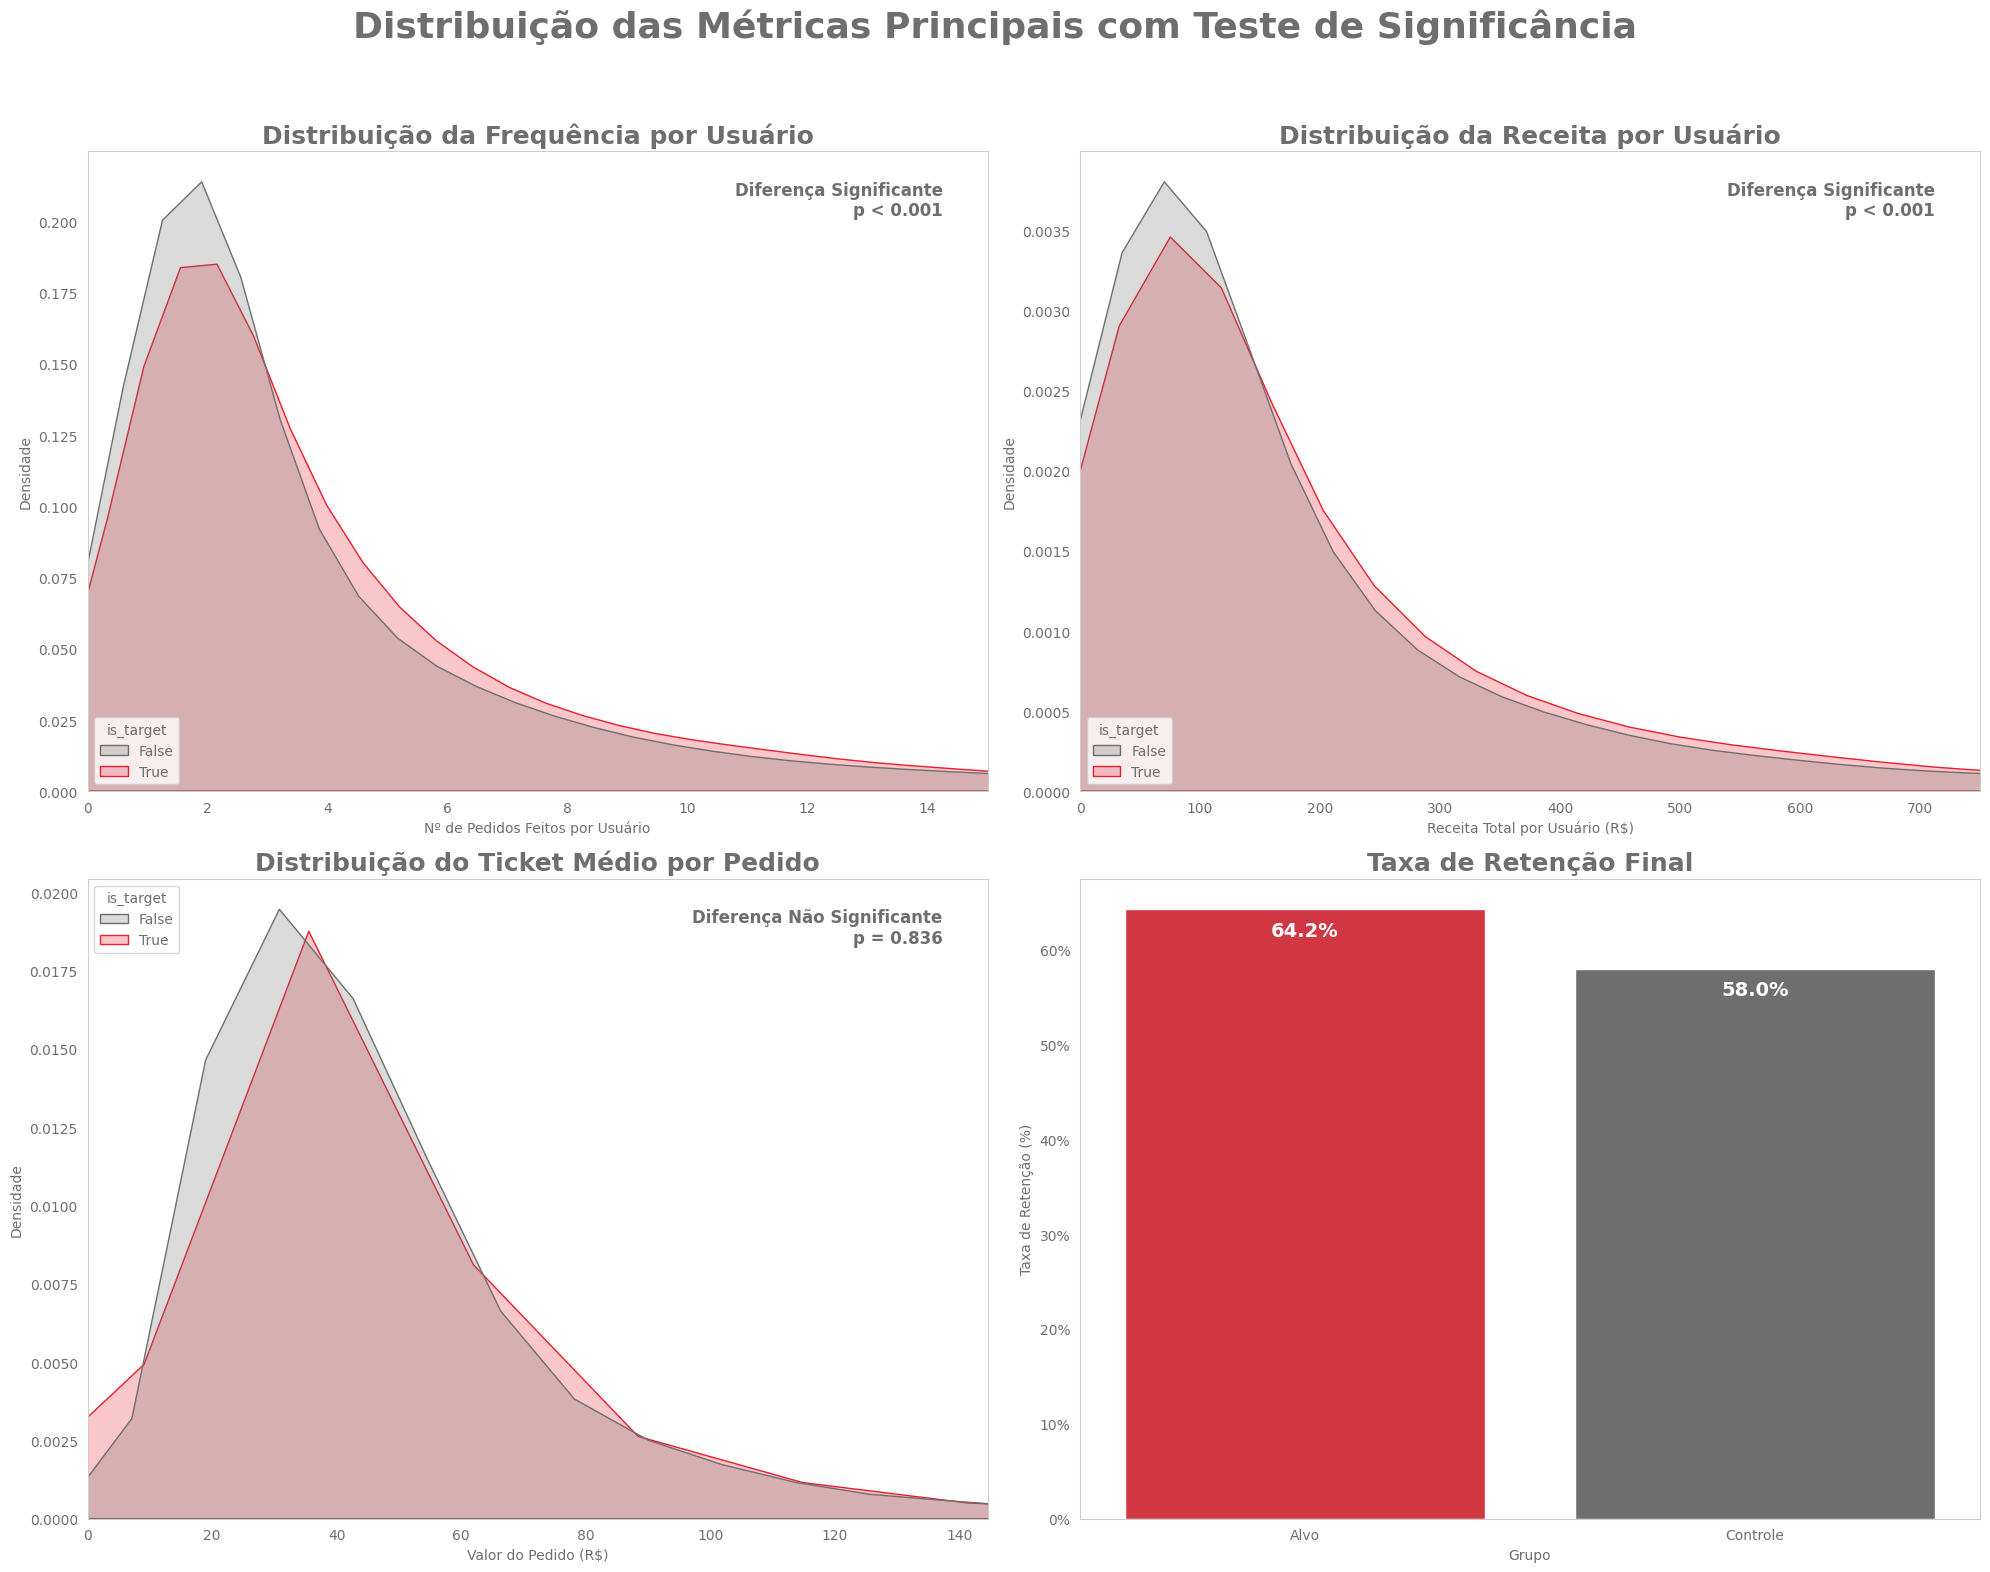

In [24]:
# ==============================================================================
#  1. PREPARAÇÃO DOS DADOS PARA PLOTAGEM
# ==============================================================================
print("Preparando dados agregados para os gráficos...")

# 1.1 Dados para Frequência por Usuário
df_freq_per_user = df_all_data.groupBy("customer_id", "is_target").agg(
    count("order_id").alias("frequencia_usuario")
)
freq_pd_sample = df_freq_per_user.sample(fraction=0.1, seed=42).toPandas()

# 1.2 Dados para Receita por Usuário
df_revenue_per_user = df_all_data.groupBy("customer_id", "is_target").agg(
    sum("order_total_amount").alias("receita_usuario")
)
revenue_pd_sample = df_revenue_per_user.sample(fraction=0.1, seed=42).toPandas()

# 1.3 Dados para Ticket Médio por Pedido
df_ticket_sample = df_all_data.select("order_total_amount", "is_target").sample(fraction=0.05, seed=42).toPandas()

# 1.4 Dados para Taxa de Retenção
retention_pd = df_retention_final.toPandas()
retention_pd['is_target'] = retention_pd['is_target'].map({True: 'Alvo', False: 'Controle'})


# ==============================================================================
#  2. VISUALIZAÇÃO COM TESTES ESTATÍSTICOS
# ==============================================================================
print("Gerando painel de gráficos de distribuição com p-valor...")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Distribuição das Métricas Principais com Teste de Significância', fontsize=26, weight='bold')

# --- Função auxiliar para o teste e anotação ---
def plotar_com_pval(ax, data, x_col, title, xlabel, xlim):
    """Realiza o teste t, plota o KDE e anota o p-valor."""
    controle = data[data['is_target'] == False][x_col].dropna()
    alvo = data[data['is_target'] == True][x_col].dropna()
    
    # Realiza o teste t
    _, p_valor = ttest_ind(alvo, controle, equal_var=False)
    
    # Plota o gráfico de densidade
    sns.kdeplot(data=data, x=x_col, hue='is_target', palette=hue_palette, 
                common_norm=False, fill=True, ax=ax, bw_adjust=1.5) # Curvas mais suaves
    
    # Anota o p-valor no gráfico
    p_text = "p < 0.001" if p_valor < 0.001 else f"p = {p_valor:.3f}"
    resultado_text = "Diferença Significante" if p_valor < 0.05 else "Diferença Não Significante"
    ax.text(0.95, 0.9, f'{resultado_text}\n{p_text}', transform=ax.transAxes,
            ha='right', fontsize=12, weight='bold',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
            
    ax.set_title(title, fontsize=18, weight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Densidade')
    ax.set_xlim(0, xlim)

# --- Gráfico 1: Frequência por Usuário ---
plotar_com_pval(axes[0, 0], freq_pd_sample, 'frequencia_usuario', 
                'Distribuição da Frequência por Usuário', 
                'Nº de Pedidos Feitos por Usuário', 
                freq_pd_sample['frequencia_usuario'].quantile(0.95))

# --- Gráfico 2: Receita por Usuário ---
plotar_com_pval(axes[0, 1], revenue_pd_sample, 'receita_usuario', 
                'Distribuição da Receita por Usuário', 
                'Receita Total por Usuário (R$)', 
                revenue_pd_sample['receita_usuario'].quantile(0.95))

# --- Gráfico 3: Ticket Médio por Pedido ---
plotar_com_pval(axes[1, 0], df_ticket_sample, 'order_total_amount', 
                'Distribuição do Ticket Médio por Pedido', 
                'Valor do Pedido (R$)', 
                df_ticket_sample['order_total_amount'].quantile(0.98))

# --- Gráfico 4: Taxa de Retenção (Gráfico de Barras) ---
sns.barplot(x='is_target', y='taxa_de_retencao_%', data=retention_pd,
            palette={'Controle': ifood_palette['cinza_medio'], 'Alvo': ifood_palette['vermelho_ifood']}, ax=axes[1, 1])
axes[1, 1].set_title('Taxa de Retenção Final', fontsize=18, weight='bold')
axes[1, 1].set_xlabel('Grupo')
axes[1, 1].set_ylabel('Taxa de Retenção (%)')
axes[1, 1].yaxis.set_major_formatter(mticker.PercentFormatter())
# Adicionar anotações de dados nas barras
for p in axes[1, 1].patches:
    axes[1, 1].annotate(f"{p.get_height():.1f}%", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, -15), textcoords='offset points',
                       fontsize=14, weight='bold', color='white')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 3) Análise Geográfica

#### 3.1) Análise de Concentração regional dos pedidos

Gerando análises e mapas geográficos detalhados...


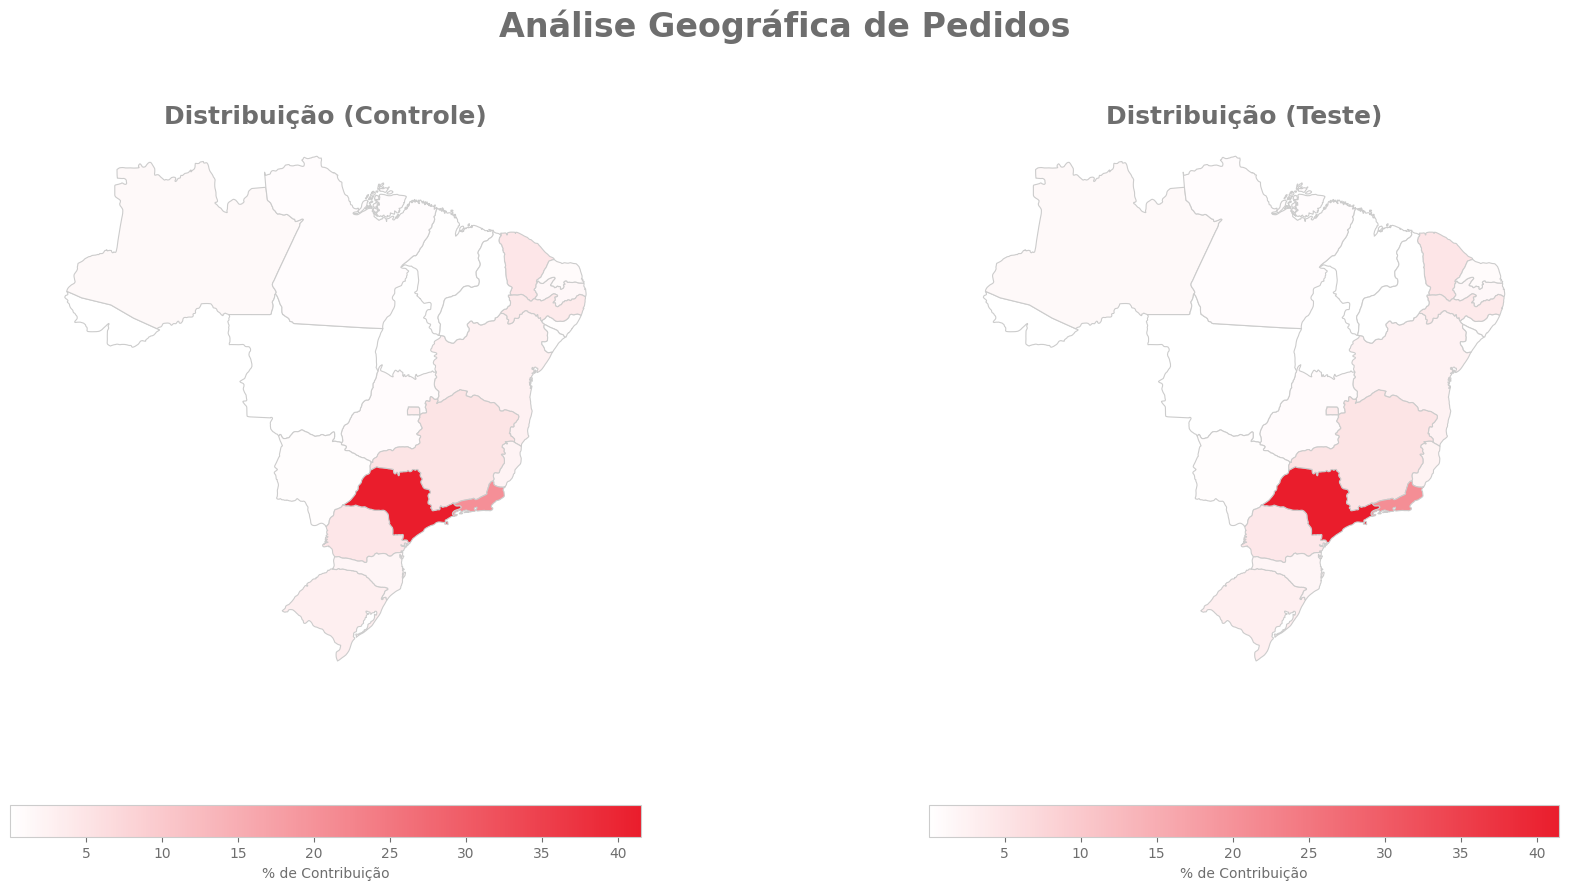

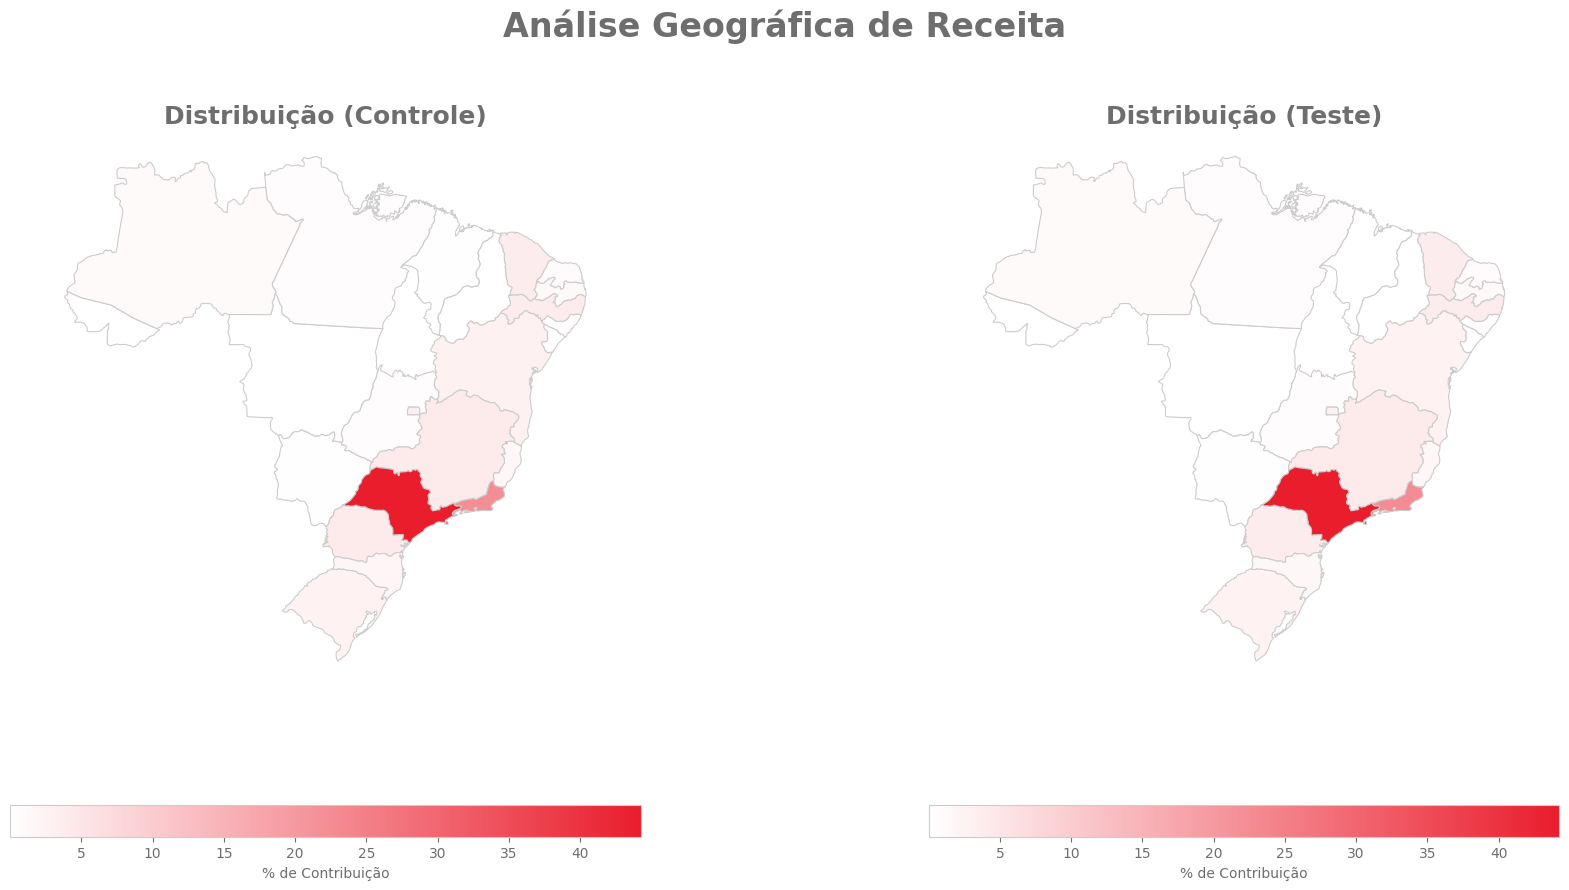

In [25]:
# ==============================================================================
#  4. ANÁLISE GEOGRÁFICA DETALHADA (VISUALIZAÇÃO LADO A LADO)
# ==============================================================================

# Paleta SEQUENCIAL para Distribuição: Branco -> Vermelho
cmap_ifood_sequencial = LinearSegmentedColormap.from_list(
    'ifood_sequential_palette',
    [ifood_palette['branco'], ifood_palette['vermelho_ifood']],
    N=256
)

print("Gerando análises e mapas geográficos detalhados...")

# --- 4.1 Agregações e Normalização no PySpark (sem alteração) ---
window_spec = Window.partitionBy("is_target")
state_metrics = df_all_data.groupBy("delivery_address_state", "is_target").agg(
    sum("order_total_amount").alias("receita_total_estado"),
    count("order_id").alias("pedidos_por_estado")
)
state_metrics_norm = state_metrics.withColumn(
    "total_receita_grupo", sum("receita_total_estado").over(window_spec)
).withColumn(
    "total_pedidos_grupo", sum("pedidos_por_estado").over(window_spec)
).withColumn(
    "pct_receita", col("receita_total_estado") / col("total_receita_grupo") * 100
).withColumn(
    "pct_pedidos", col("pedidos_por_estado") / col("total_pedidos_grupo") * 100
)
state_metrics_pd = state_metrics_norm.toPandas()


# --- 4.2 Pivotar a tabela no Pandas (sem alteração) ---
orders_pivot = state_metrics_pd.pivot_table(index="delivery_address_state", columns="is_target", values="pct_pedidos").reset_index()
orders_pivot.columns = ['estado', 'pedidos_control_%', 'pedidos_target_%']
revenue_pivot = state_metrics_pd.pivot_table(index="delivery_address_state", columns="is_target", values="pct_receita").reset_index()
revenue_pivot.columns = ['estado', 'receita_control_%', 'receita_target_%']

comparison_df = pd.merge(orders_pivot, revenue_pivot, on="estado")

# --- 4.3 Carregar o mapa do Brasil e juntar os dados (sem alteração) ---
url_geojson = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/Brasil.json"
geo_br = gpd.read_file(url_geojson)
merged_comparison_data = geo_br.set_index('UF').join(comparison_df.set_index('estado'))


# --- 4.4 Função para plotar os 2 mapas lado a lado (COM CORES CONSISTENTES) ---
def plotar_sequencia_de_mapas(geo_df, base_column_name, main_title):
    """
    Plota 2 mapas em uma linha: Controle (%) e Teste (%).
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    col_control = f'{base_column_name}_control_%'
    col_target = f'{base_column_name}_target_%'
    
    # --- Preparar dados e escalas ---
    geo_df_filtrado = geo_df.dropna(subset=[col_control, col_target])
    
    vmin_dist = builtins.min(geo_df_filtrado[col_control].min(), geo_df_filtrado[col_target].min())
    vmax_dist = builtins.max(geo_df_filtrado[col_control].max(), geo_df_filtrado[col_target].max())
    
    # --- Plotar Mapas ---
    # ##-- ALTERAÇÃO: Define a paleta de cores dinamicamente --##
    for ax, col_name, title in zip(axes, [col_control, col_target], ['Distribuição (Controle)', 'Distribuição (Teste)']):

        geo_df_filtrado.plot(column=col_name, cmap=cmap_ifood_sequencial, linewidth=0.8, ax=ax, edgecolor='0.8', 
                             legend=True, vmin=vmin_dist, vmax=vmax_dist,
                             legend_kwds={'label': '% de Contribuição', 'orientation': "horizontal", 'shrink': 0.6})
        ax.axis('off')
        ax.set_title(title, fontdict={'fontsize': '18', 'fontweight': 'bold'})
    
    fig.suptitle(main_title, fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# --- 4.5 Gerando as sequências de mapas ---
plotar_sequencia_de_mapas(merged_comparison_data, 'pedidos', 'Análise Geográfica de Pedidos')
plotar_sequencia_de_mapas(merged_comparison_data, 'receita', 'Análise Geográfica de Receita')


#### 3.2) Resultado por Estado

--- Gerando mapas para: Média de Pedidos por Usuário ---


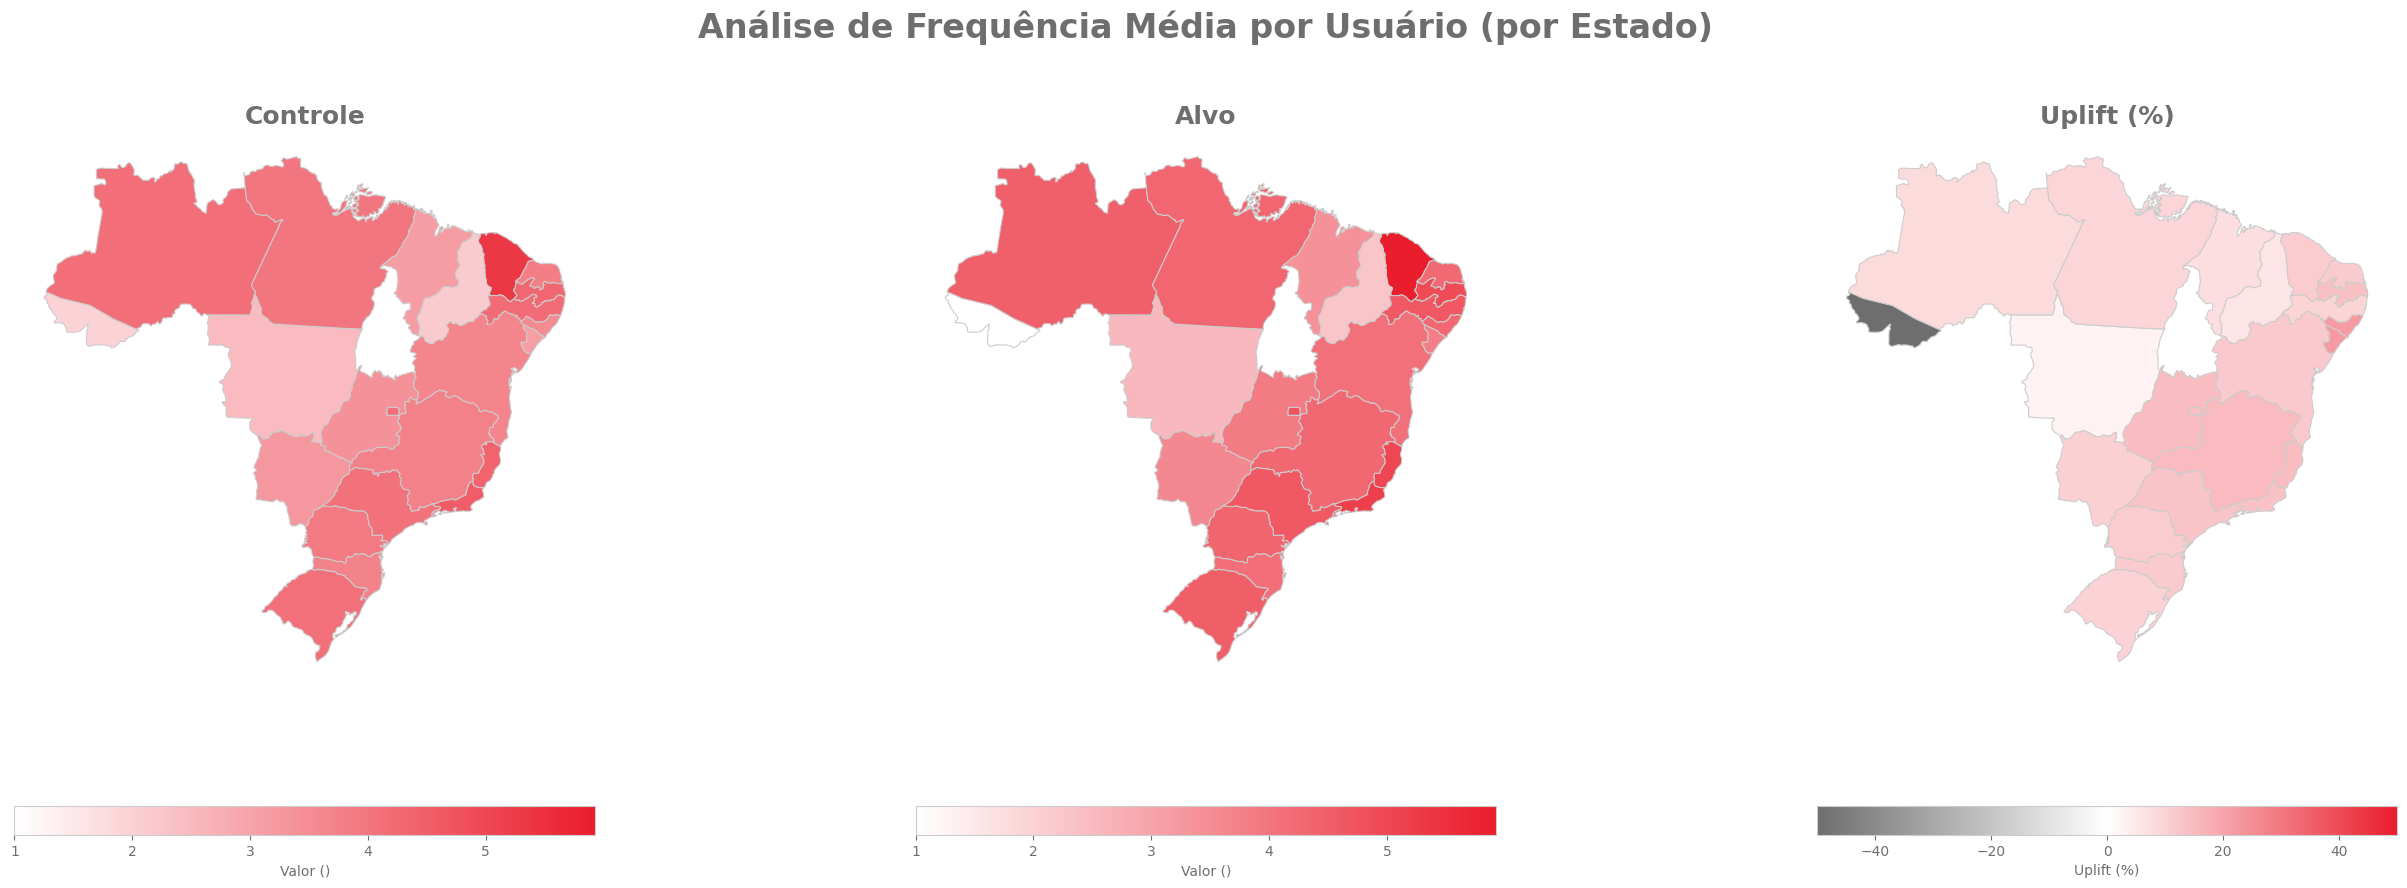


--- Gerando mapas para: Receita Média por Usuário ---


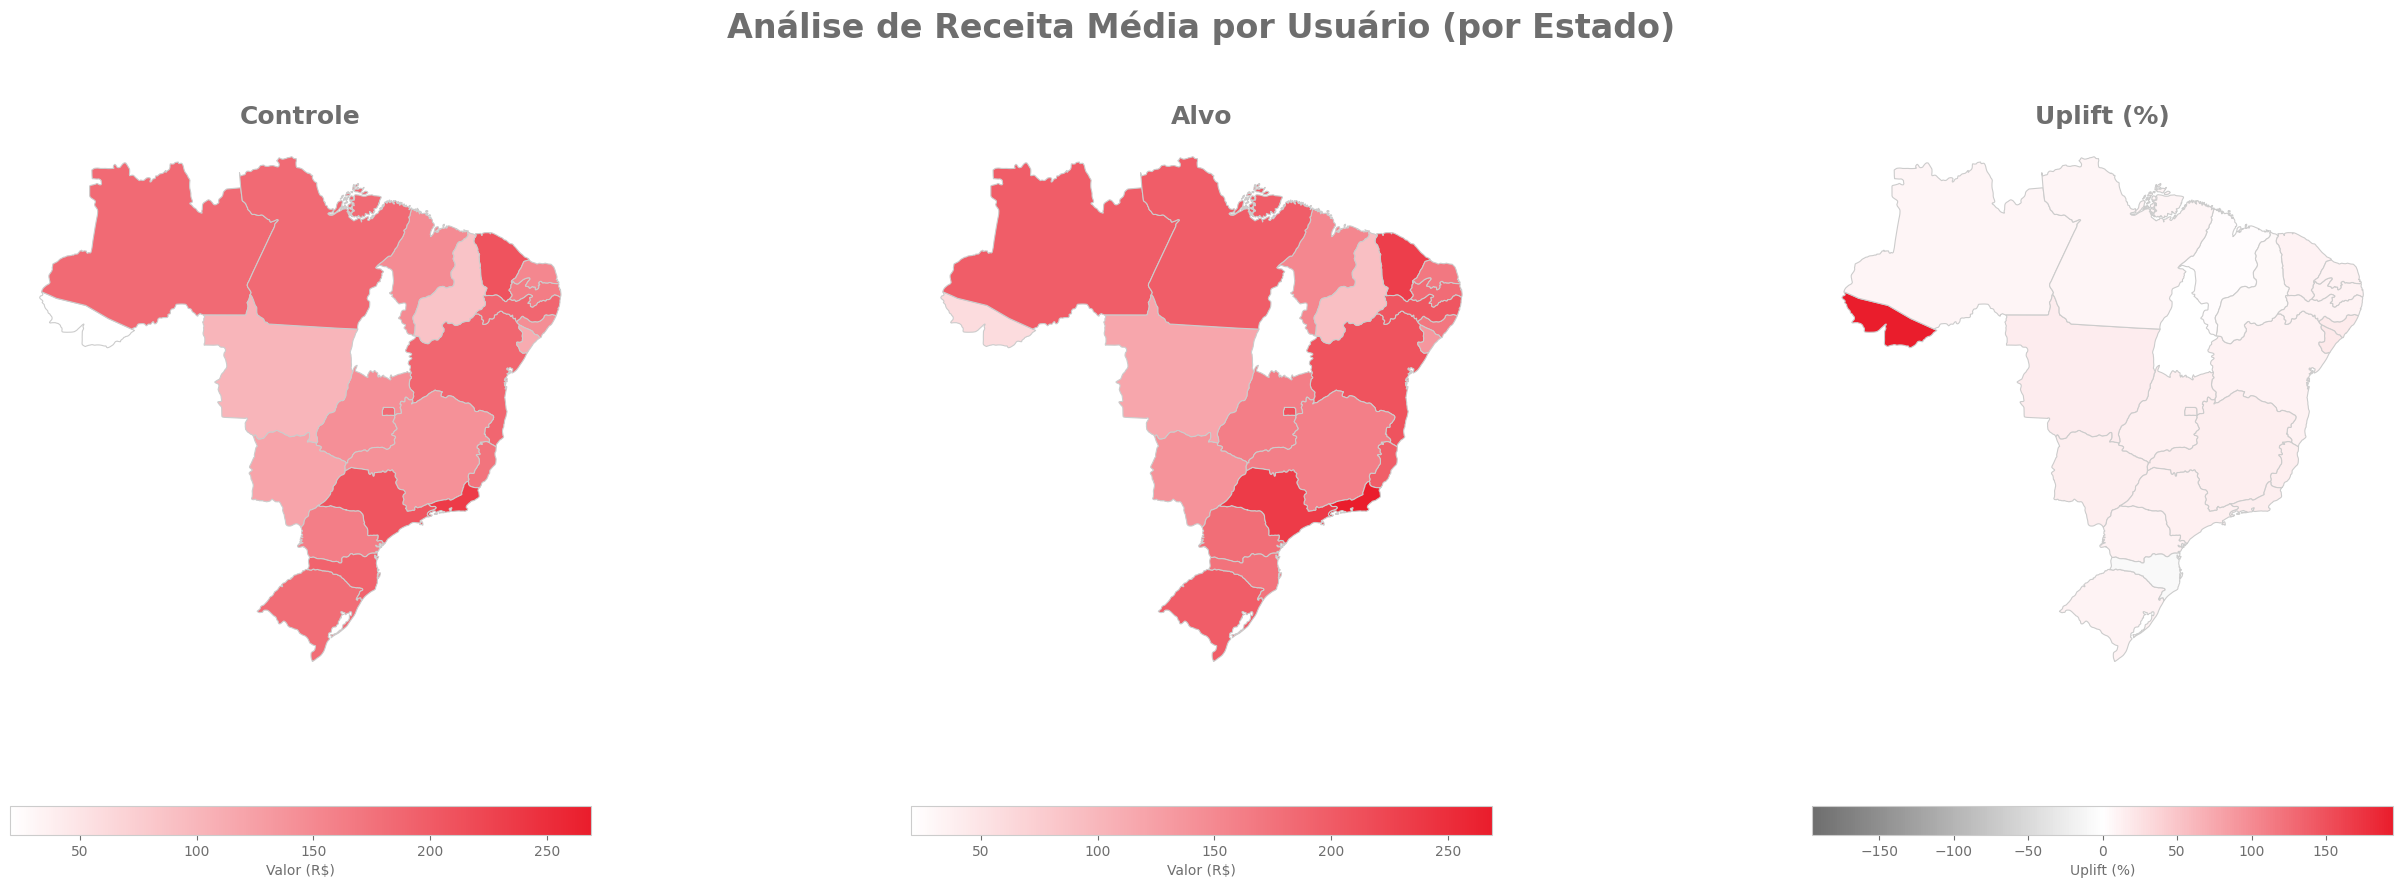


--- Gerando mapas para: Ticket Médio por Pedido ---


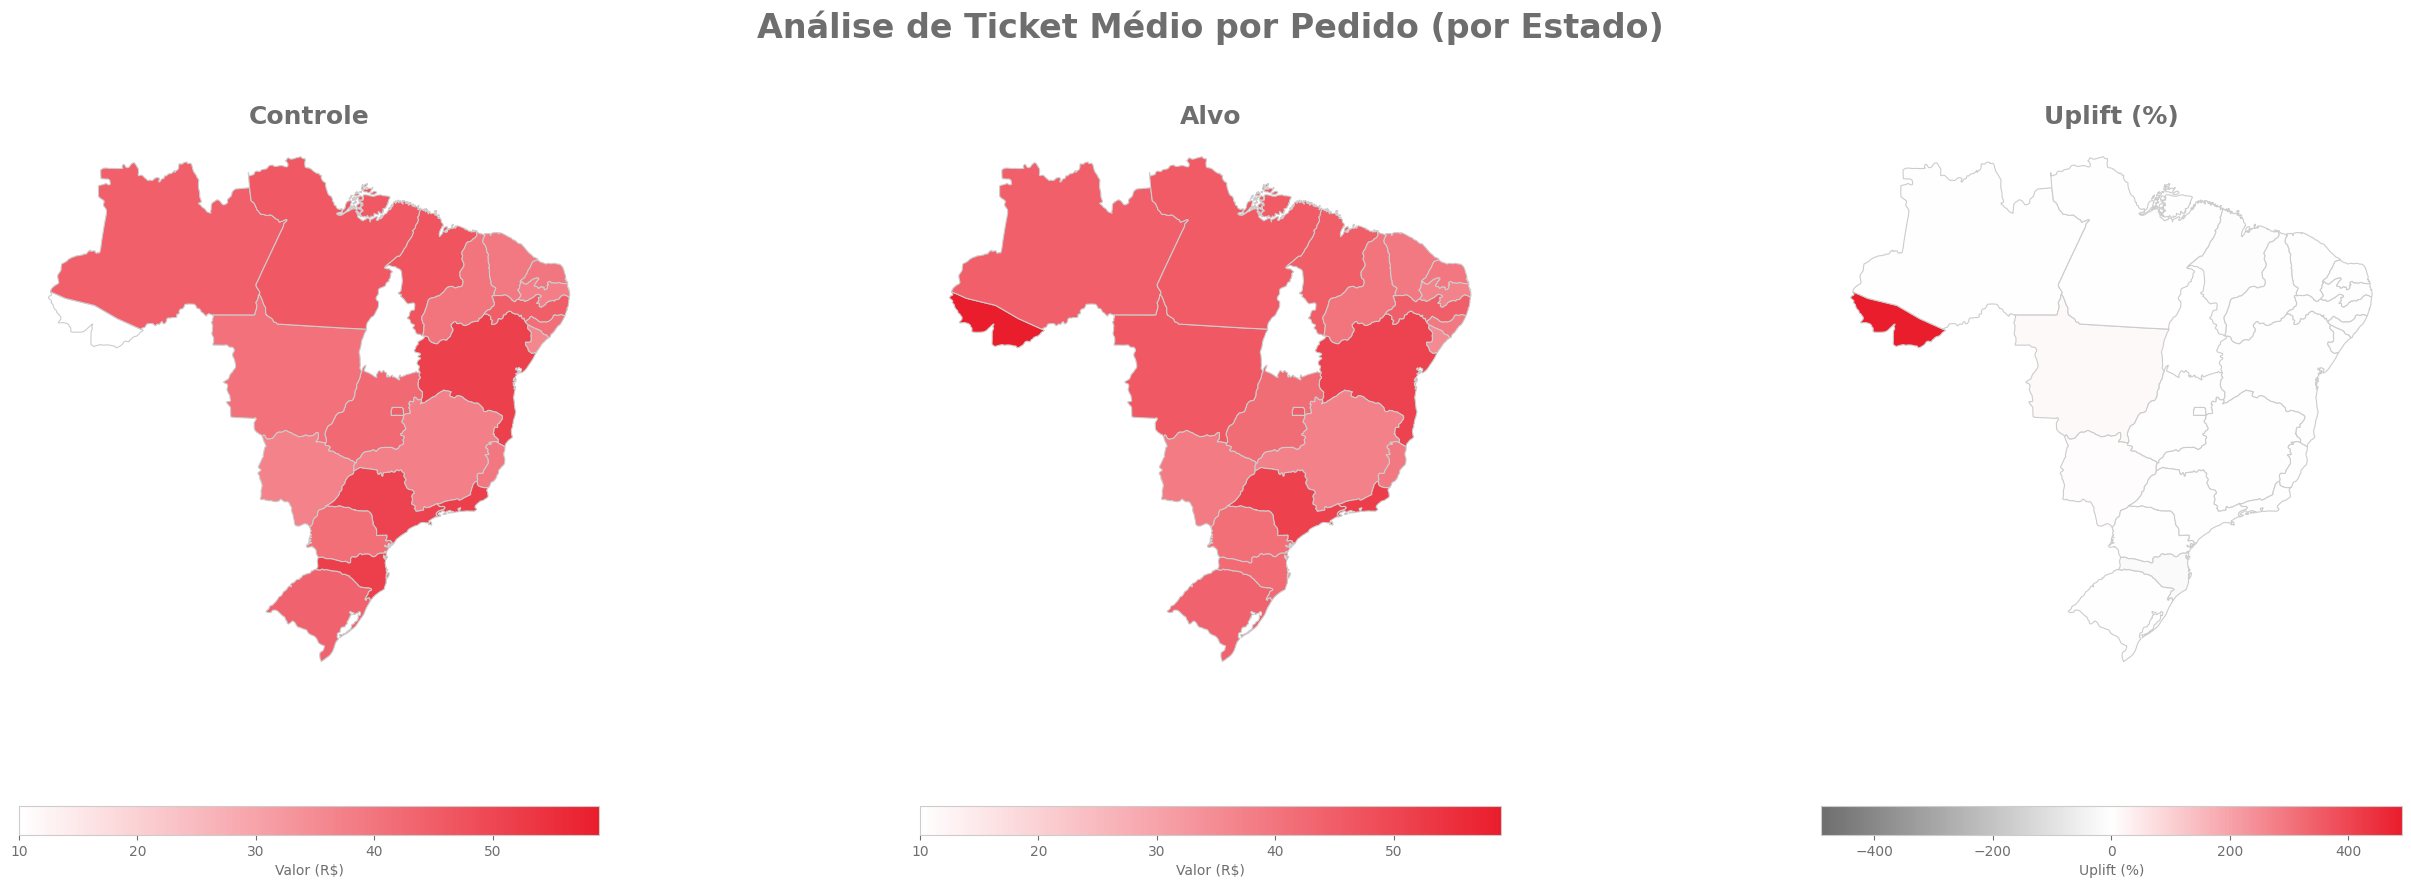


--- Gerando mapas para: Taxa de Retenção por Estado ---
Calculando o estado principal de cada cliente...
Juntando atividade do cliente com seu estado principal...
Calculando a taxa de retenção por estado...


Gerando os mapas de retenção...


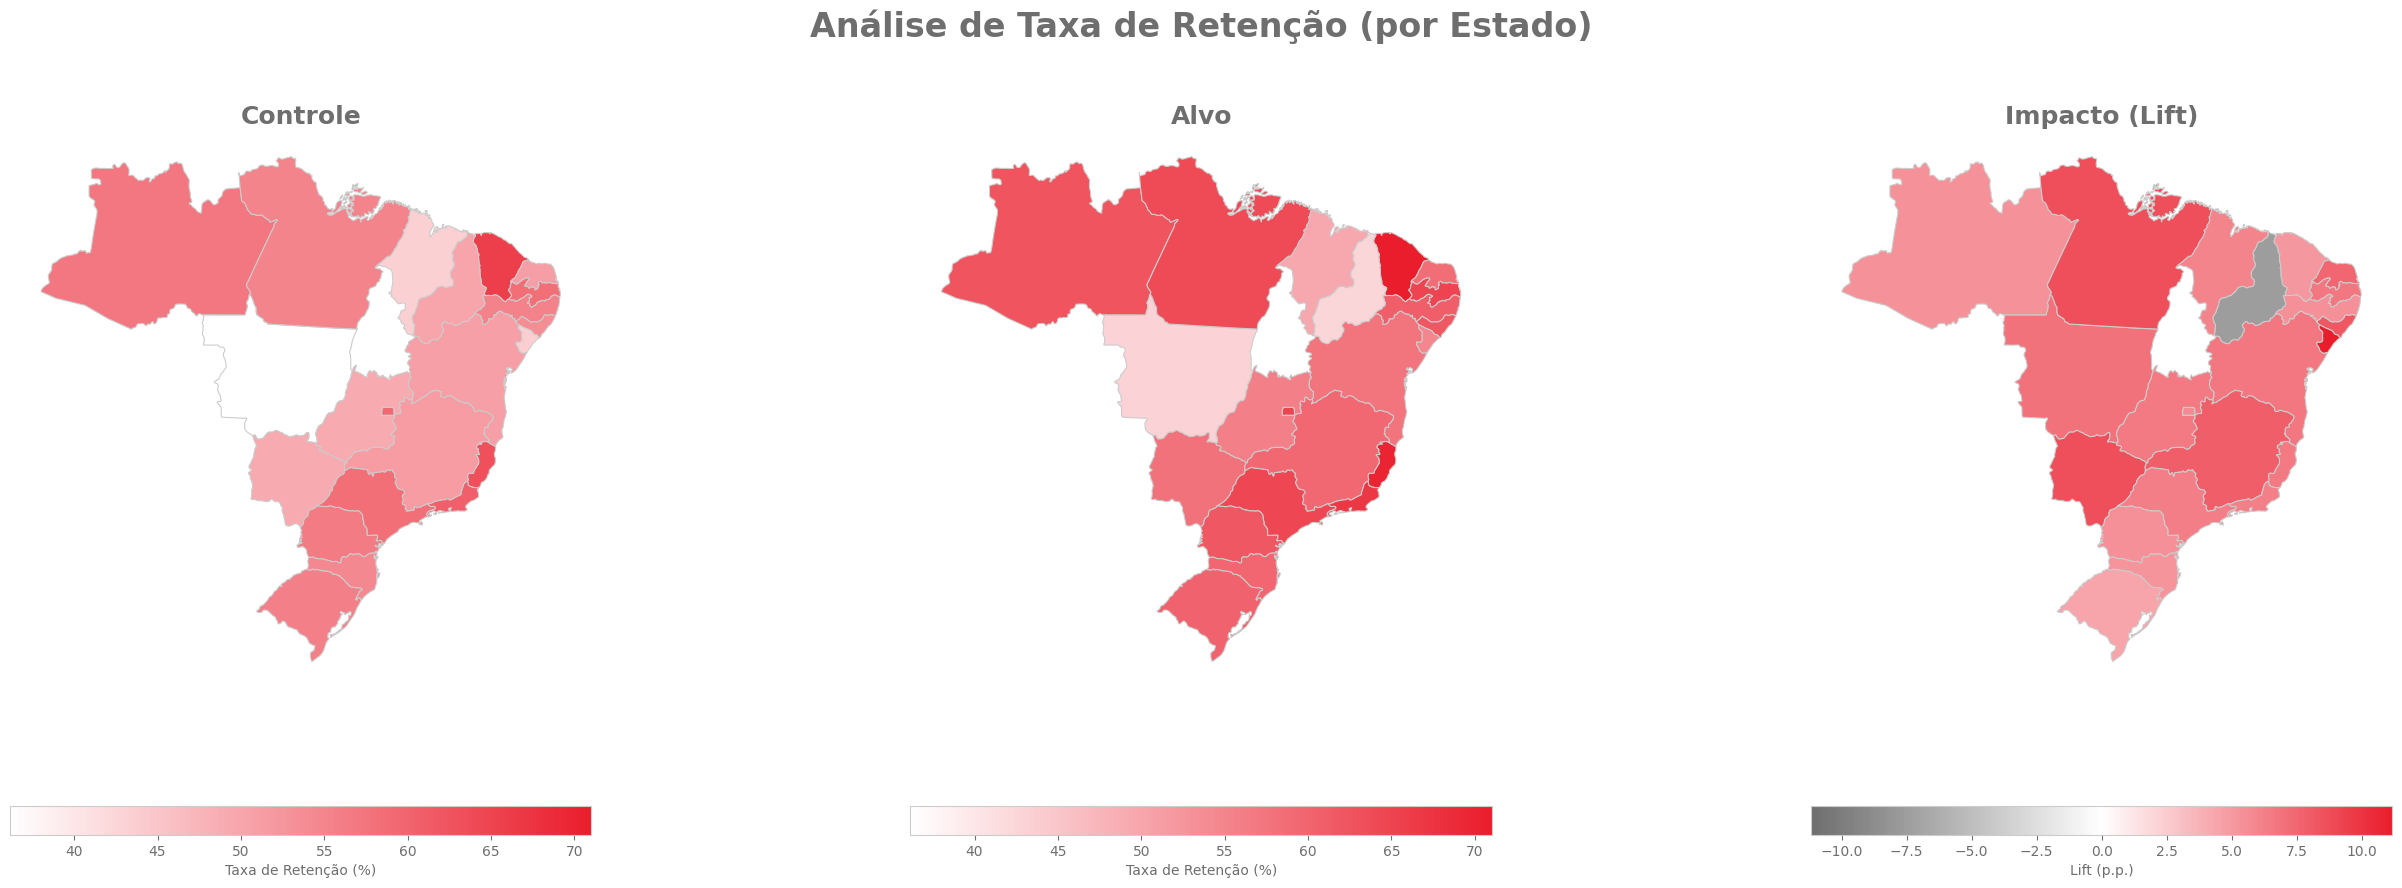

In [27]:
url_geojson = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/Brasil.json"
geo_br = gpd.read_file(url_geojson)

cmap_ifood_divergente = LinearSegmentedColormap.from_list(
    'ifood_uplift_palette',
    [ifood_palette['cinza_medio'], ifood_palette['branco'], ifood_palette['vermelho_ifood']],
    N=256
)

# Paleta SEQUENCIAL para Distribuição: Branco -> Vermelho
cmap_ifood_sequencial = LinearSegmentedColormap.from_list(
    'ifood_sequential_palette',
    [ifood_palette['branco'], ifood_palette['vermelho_ifood']],
    N=256
)

# --- FUNÇÃO DE PLOTAGEM GERAL (com a correção da paleta) ---
def plotar_sequencia_de_mapas(geo_df, base_column_name, main_title, unit_prefix="", unit_suffix=""):
    fig, axes = plt.subplots(1, 3, figsize=(28, 10))
    col_control = f'{base_column_name}_control'
    col_target = f'{base_column_name}_target'
    col_uplift = f'uplift_{base_column_name}_%'
    
    geo_df_filtrado = geo_df.dropna(subset=[col_control, col_target, col_uplift])
    
    # Escala consistente para os mapas de Controle e Teste
    vmin_dist = builtins.min(geo_df_filtrado[col_control].min(), geo_df_filtrado[col_target].min())
    vmax_dist = builtins.max(geo_df_filtrado[col_control].max(), geo_df_filtrado[col_target].max())
    
    # Escala divergente para o mapa de Uplift
    vmax_uplift = geo_df_filtrado[col_uplift].abs().max()
    vmin_uplift = -vmax_uplift
    
    # ##-- CORREÇÃO: Usando a mesma paleta 'Reds' para ambos os mapas de distribuição --##
    # Mapas de Controle e Teste
    for ax, col_name, title in zip(axes[:2], [col_control, col_target], ['Controle', 'Alvo']):
        geo_df_filtrado.plot(column=col_name, cmap=cmap_ifood_sequencial, linewidth=0.8, ax=ax, edgecolor='0.8', 
                             legend=True, vmin=vmin_dist, vmax=vmax_dist,
                             legend_kwds={'label': f'Valor ({unit_prefix}{unit_suffix})', 'orientation': "horizontal", 'shrink': 0.6})
        ax.axis('off')
        ax.set_title(title, fontdict={'fontsize': '18', 'fontweight': 'bold'})

    # Mapa 3: Uplift
    geo_df_filtrado.plot(column=col_uplift, cmap=cmap_ifood_divergente, linewidth=0.8, ax=axes[2], edgecolor='0.8',
                         legend=True, vmin=vmin_uplift, vmax=vmax_uplift,
                         legend_kwds={'label': 'Uplift (%)', 'orientation': "horizontal", 'shrink': 0.6})

    axes[2].axis('off')
    axes[2].set_title('Uplift (%)', fontdict={'fontsize': '18', 'fontweight': 'bold'})
    
    fig.suptitle(main_title, fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# --- FUNÇÃO AUXILIAR PARA PREPARAR OS DADOS (sem alteração) ---
def preparar_dados_para_mapa(df_agg_spark, metrica):
    df_pd = df_agg_spark.toPandas()
    df_pivot = df_pd.pivot_table(index="delivery_address_state", columns="is_target", values=metrica).reset_index()
    df_pivot.columns = ['estado', f'{metrica}_control', f'{metrica}_target']
    df_pivot[f'uplift_{metrica}_%'] = ((df_pivot[f'{metrica}_target'] - df_pivot[f'{metrica}_control']) / df_pivot[f'{metrica}_control']) * 100
    return geo_br.set_index('UF').join(df_pivot.set_index('estado'))

# ==============================================================================
#  ANÁLISE 1: Média de Pedidos por Usuário (por Estado)
# ==============================================================================
print("--- Gerando mapas para: Média de Pedidos por Usuário ---")
# Import 'max' com alias para evitar conflito

freq_por_estado = df_all_data.groupBy("delivery_address_state", "is_target").agg(
    (count("order_id") / countDistinct("customer_id")).alias("frequencia_media")
)
geo_data_freq = preparar_dados_para_mapa(freq_por_estado, "frequencia_media")
plotar_sequencia_de_mapas(geo_data_freq, "frequencia_media", "Análise de Frequência Média por Usuário (por Estado)")


# ==============================================================================
#  ANÁLISE 2: Receita Média por Usuário (por Estado)
# ==============================================================================
print("\n--- Gerando mapas para: Receita Média por Usuário ---")
receita_por_usuario_estado = df_all_data.groupBy("delivery_address_state", "is_target").agg(
    (sum("order_total_amount") / countDistinct("customer_id")).alias("receita_media_usuario")
)
geo_data_receita = preparar_dados_para_mapa(receita_por_usuario_estado, "receita_media_usuario")
plotar_sequencia_de_mapas(geo_data_receita, "receita_media_usuario", "Análise de Receita Média por Usuário (por Estado)", unit_prefix="R$")


# ==============================================================================
#  ANÁLISE 3: Ticket Médio por Pedido (por Estado)
# ==============================================================================
print("\n--- Gerando mapas para: Ticket Médio por Pedido ---")
ticket_medio_estado = df_all_data.groupBy("delivery_address_state", "is_target").agg(
    avg("order_total_amount").alias("ticket_medio")
)
geo_data_ticket = preparar_dados_para_mapa(ticket_medio_estado, "ticket_medio")
plotar_sequencia_de_mapas(geo_data_ticket, "ticket_medio", "Análise de Ticket Médio por Pedido (por Estado)", unit_prefix="R$")


# Função auxiliar para pivotar os dados
def preparar_dados_para_mapa(df_agg_spark, metrica):
    df_pd = df_agg_spark.toPandas()
    df_pivot = df_pd.pivot_table(index="delivery_address_state", columns="is_target", values=metrica).reset_index()
    df_pivot.columns = ['estado', f'{metrica}_control', f'{metrica}_target']
    return geo_br.set_index('sigla').join(df_pivot.set_index('estado'))

# Função de plotagem para a sequência de 3 mapas
def plotar_sequencia_de_mapas(geo_df, control_col, target_col, uplift_col, main_title, uplift_label):
    fig, axes = plt.subplots(1, 3, figsize=(28, 10))
    
    geo_df_filtrado = geo_df.dropna(subset=[control_col, target_col, uplift_col])
    
    # Escalas
    vmin_dist = builtins.min(geo_df_filtrado[control_col].min(), geo_df_filtrado[target_col].min())
    vmax_dist = builtins.max(geo_df_filtrado[control_col].max(), geo_df_filtrado[target_col].max())
    vmax_uplift = geo_df_filtrado[uplift_col].abs().max()
    vmin_uplift = -vmax_uplift
    
    # Mapas de Controle (cinza) e Teste (vermelho)
    for ax, col_name, title, cmap in zip(axes[:2], [control_col, target_col], ['Controle', 'Alvo'], ['Greys', 'Reds']):
        geo_df_filtrado.plot(column=col_name, cmap=cmap_ifood_sequencial, linewidth=0.8, ax=ax, edgecolor='0.8', 
                             legend=True, vmin=vmin_dist, vmax=vmax_dist,
                             legend_kwds={'label': 'Taxa de Retenção (%)', 'orientation': "horizontal", 'shrink': 0.6})
        ax.axis('off')
        ax.set_title(title, fontdict={'fontsize': '18', 'fontweight': 'bold'})

    # Mapa de Uplift (divergente)
    geo_df_filtrado.plot(column=uplift_col, cmap=cmap_ifood_divergente, linewidth=0.8, ax=axes[2], edgecolor='0.8',
                         legend=True, vmin=vmin_uplift, vmax=vmax_uplift,
                         legend_kwds={'label': uplift_label, 'orientation': "horizontal", 'shrink': 0.6})
    axes[2].axis('off')
    axes[2].set_title('Impacto (Lift)', fontdict={'fontsize': '18', 'fontweight': 'bold'})
    
    fig.suptitle(main_title, fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# ==============================================================================
#  ANÁLISE DE TAXA DE RETENÇÃO (POR ESTADO)
# ==============================================================================
print("\n--- Gerando mapas para: Taxa de Retenção por Estado ---")

# --- PASSO 1: Descobrir o estado principal de cada cliente ---
print("Calculando o estado principal de cada cliente...")
window_spec_state = Window.partitionBy("customer_id").orderBy(col("count").desc())
df_primary_state = df_all_data.groupBy("customer_id", "delivery_address_state").count() \
    .withColumn("rn", row_number().over(window_spec_state)) \
    .filter(col("rn") == 1) \
    .select("customer_id", "delivery_address_state")

# --- PASSO 2: Juntar a atividade com o estado principal do cliente ---
print("Juntando atividade do cliente com seu estado principal...")
# (Assumimos que o DataFrame 'df_customer_activity' foi criado anteriormente)
df_retention_state = df_customer_activity.join(df_primary_state, "customer_id", "inner")

# --- PASSO 3: Calcular a taxa de retenção por estado e grupo ---
print("Calculando a taxa de retenção por estado...")
# Filtra apenas a coorte que comprou no período 1
df_base_retencao_estado = df_retention_state.filter(col("comprou_periodo_1") == 1)

df_retention_agg_estado = df_base_retencao_estado.groupBy("delivery_address_state", "is_target").agg(
    sum("comprou_periodo_2").alias("clientes_retidos"),
    count("customer_id").alias("clientes_iniciais")
).withColumn(
    "taxa_de_retencao",
    when(col("clientes_iniciais") > 0, (col("clientes_retidos") / col("clientes_iniciais")) * 100).otherwise(0)
)

# Função auxiliar simplificada para pivotar os dados
def pivotar_e_juntar(df_agg_spark, metrica):
    df_pd = df_agg_spark.toPandas()
    df_pivot = df_pd.pivot_table(index="delivery_address_state", columns="is_target", values=metrica).reset_index()
    df_pivot.columns = ['estado', f'{metrica}_control', f'{metrica}_target']
    return geo_br.set_index('UF').join(df_pivot.set_index('estado'))


# --- PASSO 4: Pivotar os dados e calcular a diferença em pontos percentuais ---
geo_data_retencao = pivotar_e_juntar(df_retention_agg_estado, "taxa_de_retencao")
geo_data_retencao['uplift_taxa_de_retencao_pp'] = geo_data_retencao['taxa_de_retencao_target'] - geo_data_retencao['taxa_de_retencao_control']

# --- PASSO 5: Plotar os mapas ---
print("Gerando os mapas de retenção...")
plotar_sequencia_de_mapas(
    geo_data_retencao, 
    'taxa_de_retencao_control', 
    'taxa_de_retencao_target', 
    'uplift_taxa_de_retencao_pp', 
    'Análise de Taxa de Retenção (por Estado)', 
    'Lift (p.p.)'  # Label para pontos percentuais
)


### 4) Análise do comportamento temporal dos pedidos

Gerando gráficos de análise financeira normalizada...
Coletando amostra para o gráfico de densidade...


Agregando e normalizando pedidos por faixa de preço e grupo...


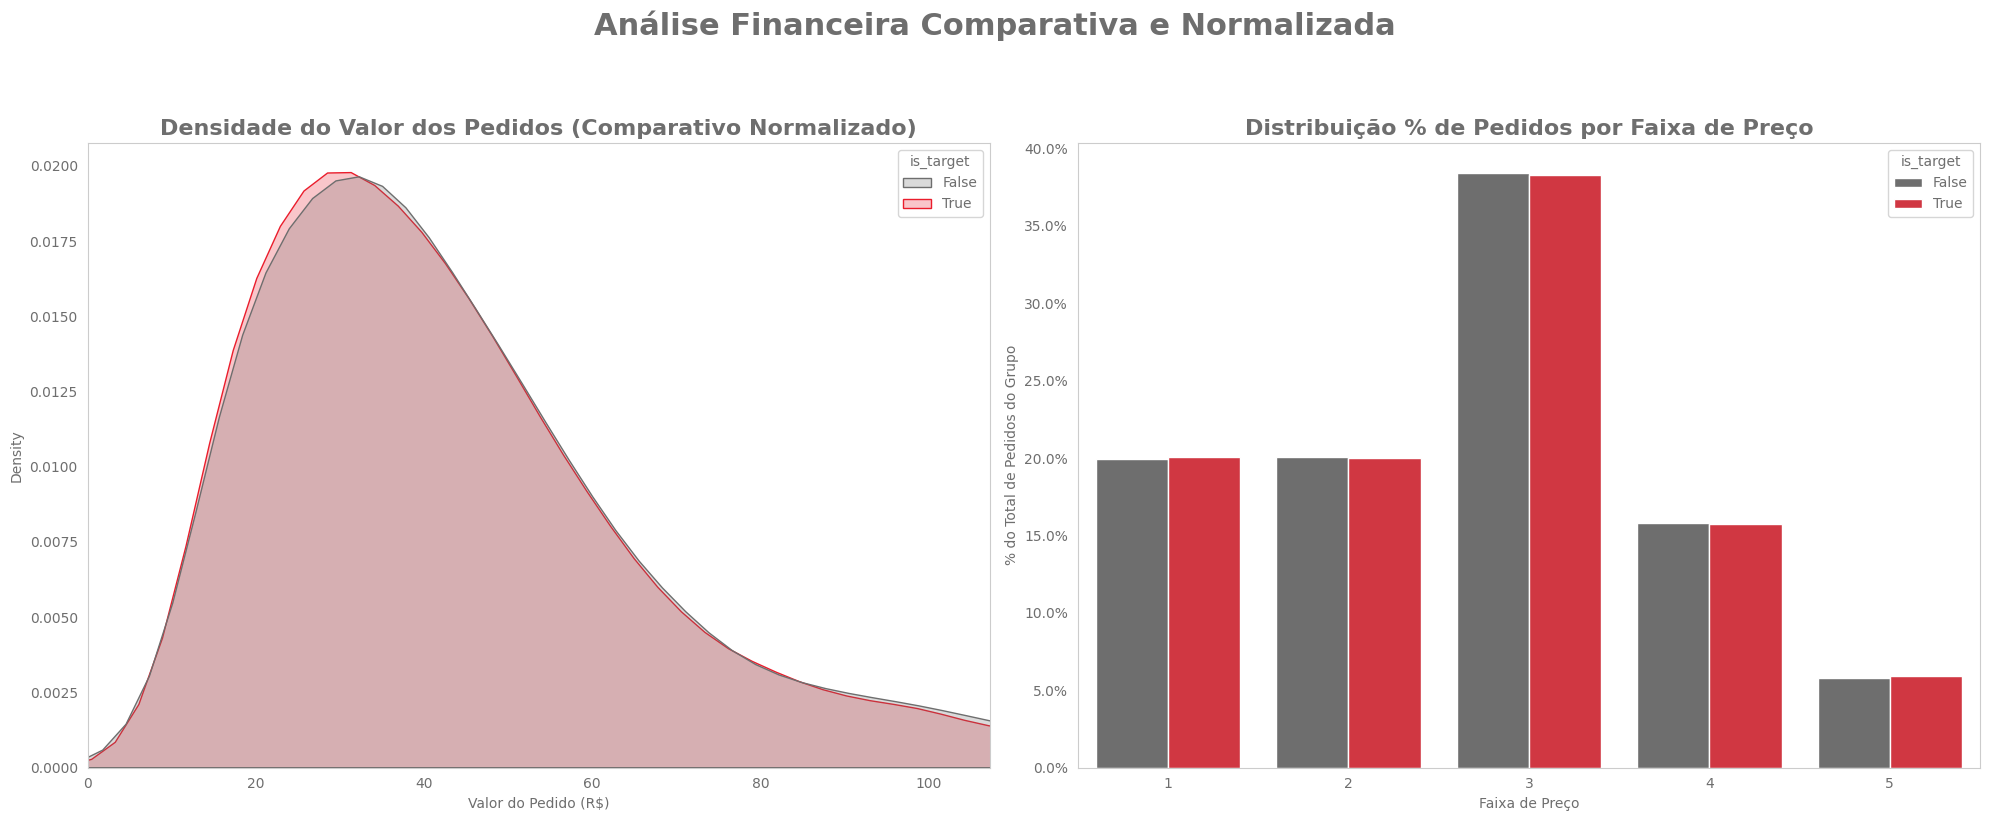

Gerando gráficos de análise temporal normalizada...


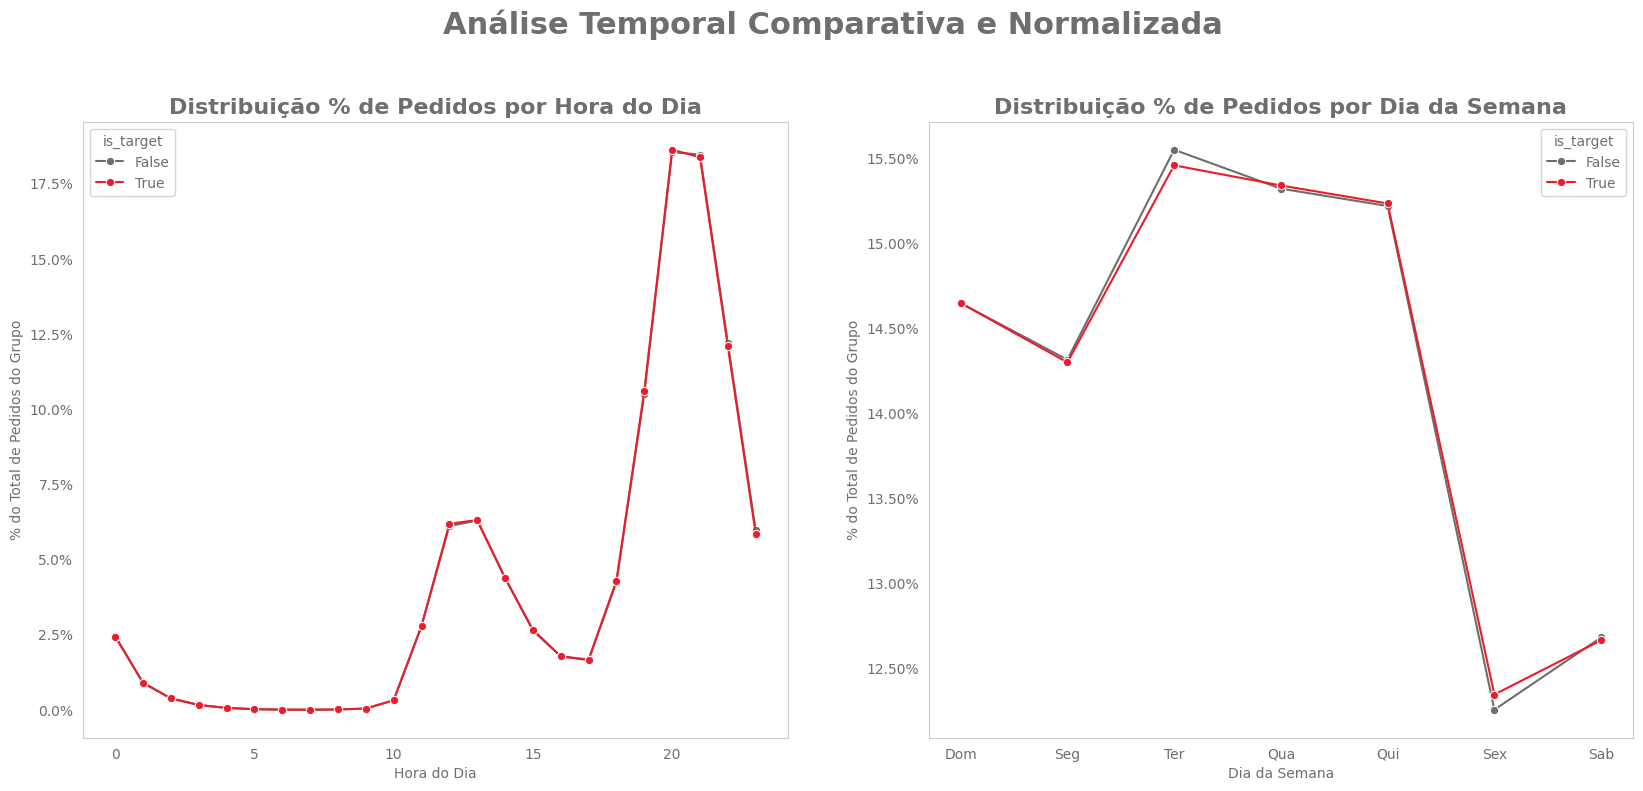

In [28]:
# Mapeando a paleta para os grupos True/False
hue_palette = {True: ifood_palette['vermelho_ifood'], False: ifood_palette['cinza_medio']}

# ==============================================================================
#  1. ANÁLISE FINANCEIRA COMPARATIVA E NORMALIZADA (Gráfico de Linha)
# ==============================================================================
print("Gerando gráficos de análise financeira normalizada...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- Gráfico Comparativo da Densidade do Valor do Pedido (Apenas Linhas) ---
print("Coletando amostra para o gráfico de densidade...")
df_sample_pd = df_all_data.select("order_total_amount", "is_target").sample(fraction=0.01, seed=42).toPandas()

# ##-- ALTERAÇÃO --##
# Trocamos 'histplot' por 'kdeplot' para mostrar apenas as linhas de distribuição.
# O parâmetro 'fill=True' adiciona uma área sombreada para melhor visualização.
sns.kdeplot(data=df_sample_pd, x='order_total_amount', hue='is_target', 
            palette=hue_palette, ax=ax1, common_norm=False, fill=True)

ax1.set_title('Densidade do Valor dos Pedidos (Comparativo Normalizado)', fontsize=16, weight='bold')
ax1.set_xlabel('Valor do Pedido (R$)')
ax1.set_xlim(0, df_sample_pd['order_total_amount'].quantile(0.95)) # Mantém o foco na maioria dos dados

# --- Distribuição Percentual de Pedidos por Faixa de Preço ---
# (Este gráfico permanece o mesmo)
print("Agregando e normalizando pedidos por faixa de preço e grupo...")
window_spec = Window.partitionBy("is_target")

price_range_agg = df_all_data.groupBy("price_range", "is_target").count()
price_range_norm = price_range_agg.withColumn("total_pedidos_grupo", sum("count").over(window_spec)) \
                                  .withColumn("percentual", col("count") / col("total_pedidos_grupo"))

price_range_pd = price_range_norm.orderBy("price_range").toPandas()

sns.barplot(x='price_range', y='percentual', hue='is_target', data=price_range_pd, palette=hue_palette, ax=ax2)
ax2.set_title('Distribuição % de Pedidos por Faixa de Preço', fontsize=16, weight='bold')
ax2.set_xlabel('Faixa de Preço')
ax2.set_ylabel('% do Total de Pedidos do Grupo')
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

plt.suptitle('Análise Financeira Comparativa e Normalizada', fontsize=22, weight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ==============================================================================
#  2. ANÁLISE TEMPORAL COMPARATIVA E NORMALIZADA
# ==============================================================================
print("Gerando gráficos de análise temporal normalizada...")

# --- Análise por Hora ---
orders_by_hour_agg = df_all_data.groupBy(hour("order_created_at").alias("hora"), "is_target").count()
orders_by_hour_norm = orders_by_hour_agg.withColumn("total_pedidos_grupo", sum("count").over(window_spec)) \
                                        .withColumn("percentual", col("count") / col("total_pedidos_grupo"))
orders_by_hour_pd = orders_by_hour_norm.orderBy("hora").toPandas()

# --- Análise por Dia da Semana ---
orders_by_day_agg = df_all_data.groupBy(dayofweek("order_created_at").alias("dia_semana"), "is_target").count()
orders_by_day_norm = orders_by_day_agg.withColumn("total_pedidos_grupo", sum("count").over(window_spec)) \
                                      .withColumn("percentual", col("count") / col("total_pedidos_grupo"))
orders_by_day_pd = orders_by_day_norm.orderBy("dia_semana").toPandas()
dias_map = {1: 'Dom', 2: 'Seg', 3: 'Ter', 4: 'Qua', 5: 'Qui', 6: 'Sex', 7: 'Sab'}
orders_by_day_pd['dia_semana'] = orders_by_day_pd['dia_semana'].map(dias_map)


# --- Plotagem ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(x='hora', y='percentual', hue='is_target', data=orders_by_hour_pd, palette=hue_palette, marker='o', ax=ax1)
ax1.set_title('Distribuição % de Pedidos por Hora do Dia', fontsize=16, weight='bold')
ax1.set_xlabel('Hora do Dia')
ax1.set_ylabel('% do Total de Pedidos do Grupo')
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

sns.lineplot(x='dia_semana', y='percentual', hue='is_target', data=orders_by_day_pd, sort=False, palette=hue_palette, marker='o', ax=ax2)
ax2.set_title('Distribuição % de Pedidos por Dia da Semana', fontsize=16, weight='bold')
ax2.set_xlabel('Dia da Semana')
ax2.set_ylabel('% do Total de Pedidos do Grupo')
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

plt.suptitle('Análise Temporal Comparativa e Normalizada', fontsize=22, weight='bold', y=1.02)
plt.show()

### 5) Análise de Clientes por data de criação

Gerando gráfico: Histórico Comparativo e Normalizado de Criação de Usuários...


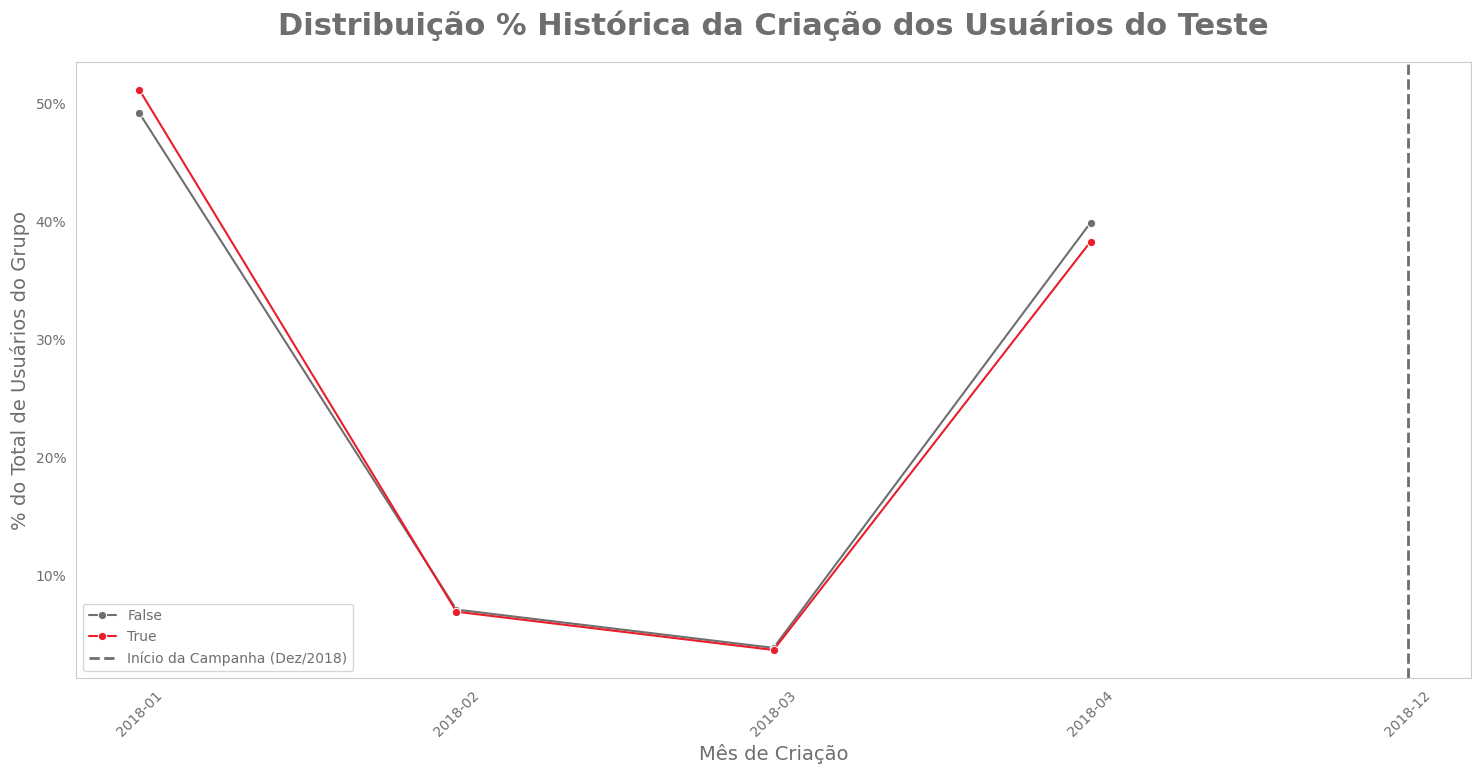

In [29]:
# ==============================================================================
#  1. VISÃO HISTÓRICA COMPARATIVA E NORMALIZADA
# ==============================================================================
print("Gerando gráfico: Histórico Comparativo e Normalizado de Criação de Usuários...")

# --- PASSO 1: Calcular as contagens mensais por grupo ---
df_criacao_mensal_agg = df_consumers_ab_test.withColumn(
    "mes_de_criacao", 
    date_format(col("created_at"), "yyyy-MM")
).groupBy("mes_de_criacao", "is_target").count()

# --- PASSO 2: Normalizar os valores usando Window Function ---
# Define a janela de partição para calcular o total por grupo
window_spec = Window.partitionBy("is_target")

# Calcula a porcentagem que cada mês representa dentro de seu grupo (Controle ou Alvo)
df_criacao_mensal_norm = df_criacao_mensal_agg.withColumn(
    "total_grupo", sum("count").over(window_spec)
).withColumn(
    "percentual", (col("count") / col("total_grupo"))
)

# Traz o resultado final para o Pandas para plotagem
df_criacao_pd_norm = df_criacao_mensal_norm.orderBy("mes_de_criacao").toPandas()


# --- PASSO 3: Plotagem do resultado normalizado ---
plt.figure(figsize=(18, 8))

# ##-- CORREÇÃO: Plotando a coluna 'percentual' no eixo Y --##
sns.lineplot(
    x='mes_de_criacao', 
    y='percentual',  # Usando a coluna normalizada
    hue='is_target', 
    data=df_criacao_pd_norm, 
    palette=hue_palette,
    marker='o'
)

# Adiciona uma linha vertical para marcar o início da campanha
plt.axvline(x='2018-12', color=ifood_palette['cinza_medio'], linestyle='--', linewidth=2, label='Início da Campanha (Dez/2018)')

plt.title('Distribuição % Histórica da Criação dos Usuários do Teste', fontsize=22, weight='bold', pad=20)
plt.xlabel('Mês de Criação', fontsize=14)
plt.ylabel('% do Total de Usuários do Grupo', fontsize=14)
# Formata o eixo Y como porcentagem
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
plt.xticks(rotation=45)
plt.legend()
plt.show()

### 6) Resultado Financeiro


### ANÁLISE DE VIABILIDADE FINANCEIRA DA CAMPANHA

#### Premissas Adotadas
- **Margem de Contribuição:** 20.0%
- **Custo por Cupom:** R$ 10,00
- **Base de Clientes para Projeção:** 55.000.000 usuários

#### Análise de Custo-Benefício (por Usuário no período de 2 meses)
- **Ganho de Receita Bruta por Usuário:** R$ 26,10  
- **Ganho de Margem (Lucro) por Usuário:** R$ 5,22  
- **Custo Estimado com Cupons por Usuário:** R$ 5,60  
**Resultado Líquido por Usuário:** **R$ -0,38**  
**ROI Imediato (2 meses):** **-6,8%**

#### Projeção Anual (Escala Nacional)
- **Ganho de Margem Anual Projetado:** R$ 1.722.600.000,00  
- **Custo com Cupons Anual Projetado:** R$ 1.848.000.000,00  
**Resultado Líquido Anual Projetado:** **R$ -125.400.000,00**

### CONCLUSÃO E RECOMENDAÇÃO FINANCEIRA

A análise financeira, sob as premissas adotadas, indica que o ROI imediato da campanha  
é marginalmente negativo. O custo para gerar os pedidos adicionais através de cupons  
supera por pouco a margem de lucro gerada por eles no curto prazo.

No entanto, esta visão é incompleta. O principal ativo gerado pela campanha foi o  
**aumento de 6,2 pontos percentuais na retenção**, o que aumenta drasticamente o  
**Valor do Ciclo de Vida do Cliente (LTV)**. Um cliente retido continua gerando receita  
e margem nos meses seguintes, um valor que supera em muito o pequeno prejuízo inicial.

**RECOMENDAÇÃO:** A iniciativa é **ESTRATEGICAMENTE VIÁVEL** e **RECOMENDADA**.  
O foco não deve ser o lucro imediato, mas a construção de uma base de clientes mais leal.  
A empresa deve aprovar o **rollout**, monitorando o LTV da coorte para quantificar o  
retorno de longo prazo e buscando **otimizar os custos com cupons** em futuras iterações.


### 7) Segmentação dos clientes

25/06/22 18:15:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:15:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:15:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:15:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:15:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:15:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 1

+--------------------+--------------+--------------------+
|         customer_id|segmento_valor|segmento_engajamento|
+--------------------+--------------+--------------------+
|922577f521c946f4e...|     Econômico|             Casuais|
|59aba492c9dde8bac...|     Econômico|             Casuais|
|b20e9076ac9fb1e1a...|     Econômico|             Casuais|
|d9cae9ad269590249...|     Econômico|             Casuais|
|31b980b0ef6e140dc...|     Econômico|             Casuais|
|280207ba97d79a5fc...|     Econômico|             Casuais|
|3947dd53a0dcab8a1...|     Econômico|             Casuais|
|7619dad16eeaa95e4...|     Econômico|             Casuais|
|63cb56840003bbef4...|     Econômico|             Casuais|
|9d805405db0da593d...|     Econômico|             Casuais|
+--------------------+--------------+--------------------+



In [ ]:
# ==============================================================================
#  PASSO 1: CRIAR OS SEGMENTOS NO PYSPARK
# =============================================================================


print("Criando segmentações de clientes...")

# 1.1 Calcular as métricas base por cliente (ticket médio e frequência)
df_customer_metrics = df_all_data.groupBy("customer_id", "is_target").agg(
    avg("order_total_amount").alias("ticket_medio_cliente"),
    count("order_id").alias("frequencia_cliente")
)

# 1.2 Criar os segmentos de VALOR e ENGAJAMENTO usando ntile (tercis)
window_ticket = Window.orderBy(col("ticket_medio_cliente"))
window_freq = Window.orderBy(col("frequencia_cliente"))

df_segmented_base = df_customer_metrics \
    .withColumn("perfil_valor_ntile", ntile(3).over(window_ticket)) \
    .withColumn("perfil_freq_ntile", ntile(3).over(window_freq))

# Mapear os tercis para nomes de segmentos
df_segmented_base = df_segmented_base.withColumn("segmento_valor",
    when(col("perfil_valor_ntile") == 1, "Econômico")
    .when(col("perfil_valor_ntile") == 2, "Padrão")
    .otherwise("Premium")
).withColumn("segmento_engajamento",
    when(col("perfil_freq_ntile") == 1, "Casuais")
    .when(col("perfil_freq_ntile") == 2, "Regulares")
    .otherwise("Fãs")
)

# 1.3 Juntar os segmentos de volta ao dataframe principal
df_segmented = df_all_data.join(
    df_segmented_base.select("customer_id", "segmento_valor", "segmento_engajamento"),
    "customer_id",
    "left"
)

# 1.4 Criar segmento GEOGRÁFICO
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}
# Cria a expressão 'when' dinamicamente
mapping_expr = when(col("delivery_address_state").isin(regioes['Norte']), "Norte")
for regiao, estados in list(regioes.items())[1:]:
    mapping_expr = mapping_expr.when(col("delivery_address_state").isin(estados), regiao)
df_segmented = df_segmented.withColumn("segmento_regiao", mapping_expr)


Criando segmentações de clientes...


In [ ]:
faixa_ticket = df_segmented_base.groupBy("segmento_valor").agg(
    spark_min("ticket_medio_cliente").alias("ticket_min"),
    spark_max("ticket_medio_cliente").alias("ticket_max"),
    count("*").alias("quantidade_clientes")
).orderBy("ticket_min")

faixa_ticket.show(truncate=False)


25/06/22 17:57:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------+----------+-----------------+-------------------+
|segmento_valor|ticket_min|ticket_max       |quantidade_clientes|
+--------------+----------+-----------------+-------------------+
|Econômico     |0.0       |33.01842105263158|268719             |
|Padrão        |33.01875  |50.17            |268719             |
|Premium       |50.17     |70169.45         |268718             |
+--------------+----------+-----------------+-------------------+



In [ ]:
faixa_frequencia = df_segmented_base.groupBy("segmento_engajamento").agg(
    spark_min("frequencia_cliente").alias("freq_min"),
    spark_max("frequencia_cliente").alias("freq_max"),
    count("*").alias("quantidade_clientes")
).orderBy("freq_min")

faixa_frequencia.show(truncate=False)


25/06/22 17:57:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 17:57:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+--------+--------+-------------------+
|segmento_engajamento|freq_min|freq_max|quantidade_clientes|
+--------------------+--------+--------+-------------------+
|Casuais             |1       |2       |268719             |
|Regulares           |2       |4       |268719             |
|Fãs                 |4       |239     |268718             |
+--------------------+--------+--------+-------------------+



In [33]:
# ==============================================================================
#  PASSO 2: AGREGAR TODOS OS DADOS NECESSÁRIOS
# ==============================================================================
print("Agregando todos os dados para a visualização final...")
# Dicionário para guardar os dataframes pandas agregados
dfs_agregados = {}

# Paleta DIVERGENTE para Uplift
cmap_ifood_divergente = LinearSegmentedColormap.from_list(
    'ifood_uplift_palette',
    [ifood_palette['cinza_medio'], ifood_palette['branco'], ifood_palette['vermelho_ifood']],
    N=256
)
# Carregar mapa do Brasil
url_geojson = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/Brasil.json"
geo_br = gpd.read_file(url_geojson)

# Agregações para cada métrica e cada tipo de segmento
for metrica_info in [
    {'nome': 'frequencia_media', 'agg_expr': (count("order_id") / countDistinct("customer_id"))},
    {'nome': 'receita_media', 'agg_expr': (sum("order_total_amount") / countDistinct("customer_id"))},
    {'nome': 'ticket_medio', 'agg_expr': avg("order_total_amount")}
]:
    for seg_col in ["segmento_valor", "segmento_engajamento", "segmento_regiao"]:
        chave = f"{metrica_info['nome']}_{seg_col}"
        df_agg = df_segmented.groupBy(seg_col, "is_target").agg(metrica_info['agg_expr'].alias(metrica_info['nome'])).toPandas()
        dfs_agregados[chave] = df_agg

# ==============================================================================
#  Agregação Específica para Retenção
# ==============================================================================
print("Iniciando agregação para a Taxa de Retenção com a lógica correta...")

# 1. Primeiro, criamos uma visão única dos segmentos por cliente para evitar duplicação.
df_customer_segments = df_segmented.select(
    "customer_id", 
    "segmento_valor", 
    "segmento_engajamento", 
    "segmento_regiao"
).distinct()

# 2. Começamos com a base de ATIVIDADE (que já é por cliente) e juntamos os segmentos.
#    Isso garante que nosso dataframe de análise tenha UMA LINHA POR CLIENTE.
df_retention_segmented = df_customer_activity.join(df_customer_segments, "customer_id", "inner")

# 3. Isolamos a coorte inicial (clientes que compraram no período 1)
df_retention_base = df_retention_segmented.filter(col("comprou_periodo_1") == 1)

# 4. Loop para analisar por cada tipo de segmento sobre a base correta (por cliente)
for seg_col in ["segmento_valor", "segmento_engajamento", "segmento_regiao"]:
    chave = f"taxa_de_retencao_{seg_col}"
    
    # A fórmula agora é aplicada sobre um dataframe com a granularidade certa
    # e protegida contra divisão por zero.
    df_agg = df_retention_base.groupBy(seg_col, "is_target").agg(
        when(
            count("customer_id") > 0,
            (sum("comprou_periodo_2") / count("customer_id")) * 100
        ).otherwise(0).alias("taxa_de_retencao")
    ).toPandas()
    
    # Armazenamos o resultado no dicionário para a plotagem
    dfs_agregados[chave] = df_agg

def plotar_uplift_mapa_regioes(ax, df_agg, geo_regioes, seg_col='segmento_regiao', metrica_col='frequencia_media', uplift_type='percent'):
    """
    Plota o mapa de uplift por região geográfica (Nordeste, Sul, etc.).
    
    Parâmetros:
    - ax: objeto Axes do matplotlib
    - df_agg: DataFrame com colunas [segmento_regiao, is_target, metrica]
    - geo_regioes: GeoDataFrame dissolvido por região
    - seg_col: nome da coluna de segmento (default: 'segmento_regiao')
    - metrica_col: nome da coluna com a métrica (default: 'frequencia_media')
    - uplift_type: 'percent' (default) ou 'absolute'
    """

    # Pivotando os dados
    df_pivot = df_agg.pivot_table(index=seg_col, columns='is_target', values=metrica_col).reset_index()
    df_pivot.columns = [seg_col, 'control', 'target']

    # Cálculo do uplift
    if uplift_type == 'percent':
        df_pivot['uplift'] = ((df_pivot['target'] - df_pivot['control']) / df_pivot['control']) * 100
    else:
        df_pivot['uplift'] = df_pivot['target'] - df_pivot['control']

    # Merge com o mapa de regiões
    merged = geo_regioes.join(df_pivot.set_index(seg_col))

    # Escala de cores
    vmax = merged['uplift'].abs().max()
    vmin = -vmax

    # Plot
    merged.plot(column='uplift', cmap=cmap_ifood_divergente, linewidth=1.5, ax=ax, edgecolor='white',
                vmin=vmin, vmax=vmax,
                legend=True, legend_kwds={'label': 'Uplift (%)' if uplift_type == 'percent' else 'Uplift Absoluto',
                                          'orientation': "horizontal", 'shrink': 0.5})

    # Labels nas regiões
    for idx, row in merged.iterrows():
        valor_uplift = row['uplift']
        sinal = "+" if valor_uplift >= 0 else ""
        label = f"{idx}\n{sinal}{valor_uplift:.1f}{'%' if uplift_type == 'percent' else ' p.p.'}"
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, label, fontsize=11,
                ha='center', va='center', weight='bold', color='#2E2E2E')

    ax.axis('off')
    # ax.set_title('Uplift de Frequência por Região Geográfica', fontdict={'fontsize': '20', 'fontweight': 'bold'})

# Carregar o mapa de ESTADOS
url_geojson = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/Brasil.json"
geo_br_estados = gpd.read_file(url_geojson)

# Dicionário para mapear siglas para nomes completos
mapa_regioes = {
    'NO': 'Norte',
    'NE': 'Nordeste',
    'CO': 'Centro-Oeste',
    'SE': 'Sudeste',
    'SU': 'Sul'
}

# Cria uma nova coluna com os nomes completos das regiões no mapa
geo_br_estados['NOME_REGIAO'] = geo_br_estados['REGIAO'].map(mapa_regioes)


geo_br_estados['geometry'] = geo_br_estados['geometry'].buffer(0)
# Agrupa (dissolve) os polígonos dos estados para criar um mapa de REGIÕES
geo_regioes = geo_br_estados.dissolve(by='NOME_REGIAO')



Agregando todos os dados para a visualização final...


25/06/22 18:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:01:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:01:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:01:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 1

Iniciando agregação para a Taxa de Retenção com a lógica correta...


25/06/22 18:03:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:03:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:03:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:03:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 1

Definindo a função de plotagem com a correção definitiva de ORDEM...

Gerando Gráfico 1 (Corrigido): Impacto por Perfil de Gasto...


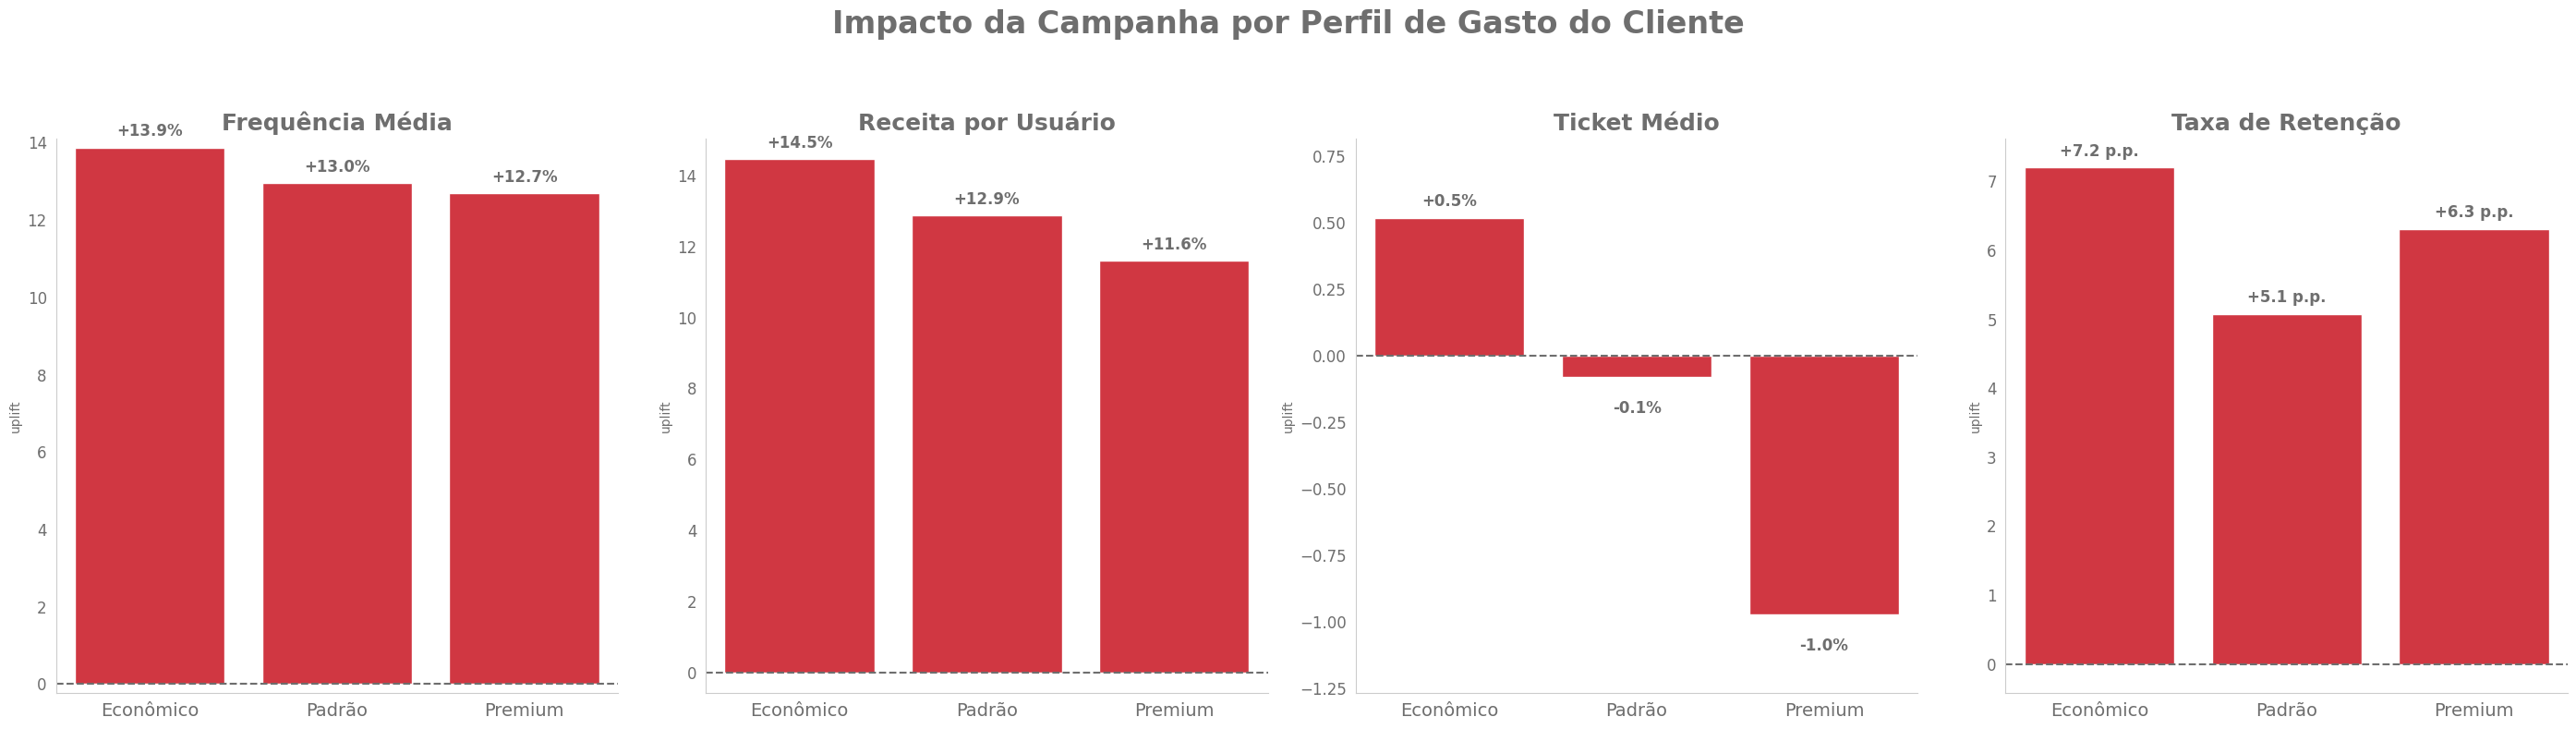


Gerando Gráfico 2 (Corrigido): Impacto por Nível de Engajamento...


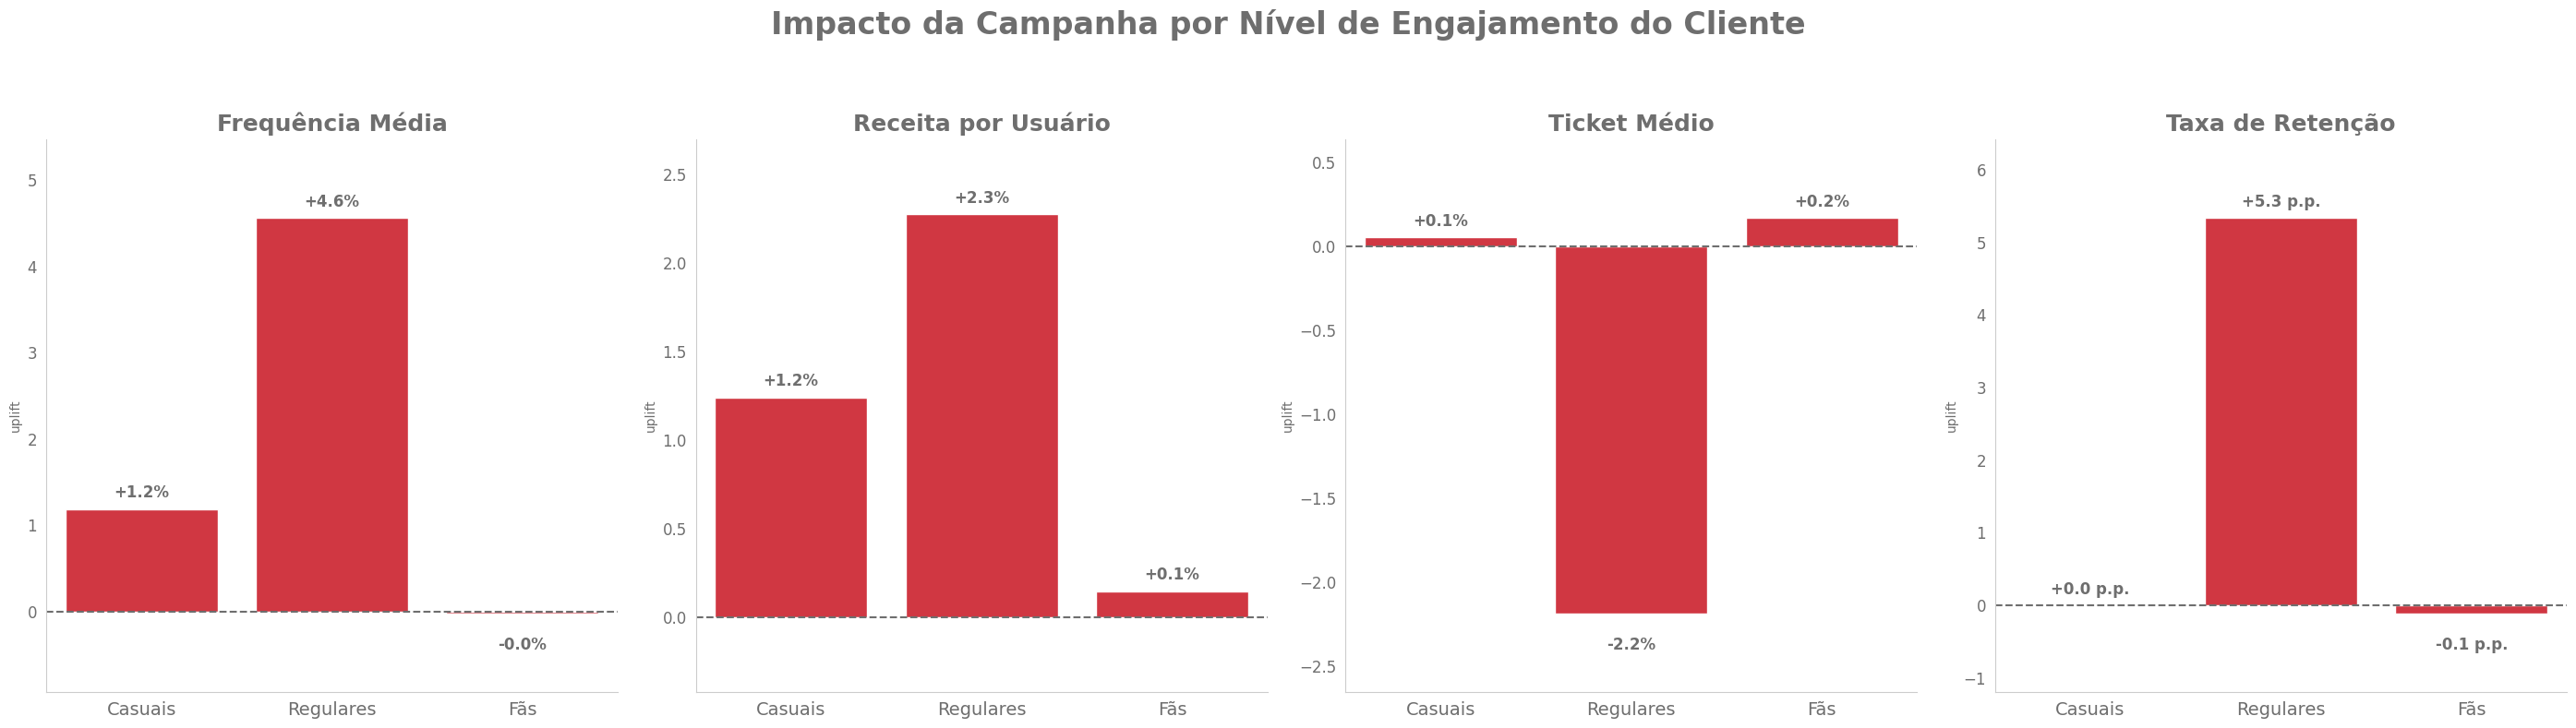


Gerando Gráfico 3: Impacto por Região Geográfica...
Gráfico 'impacto_por_regiao_geografica.png' salvo.


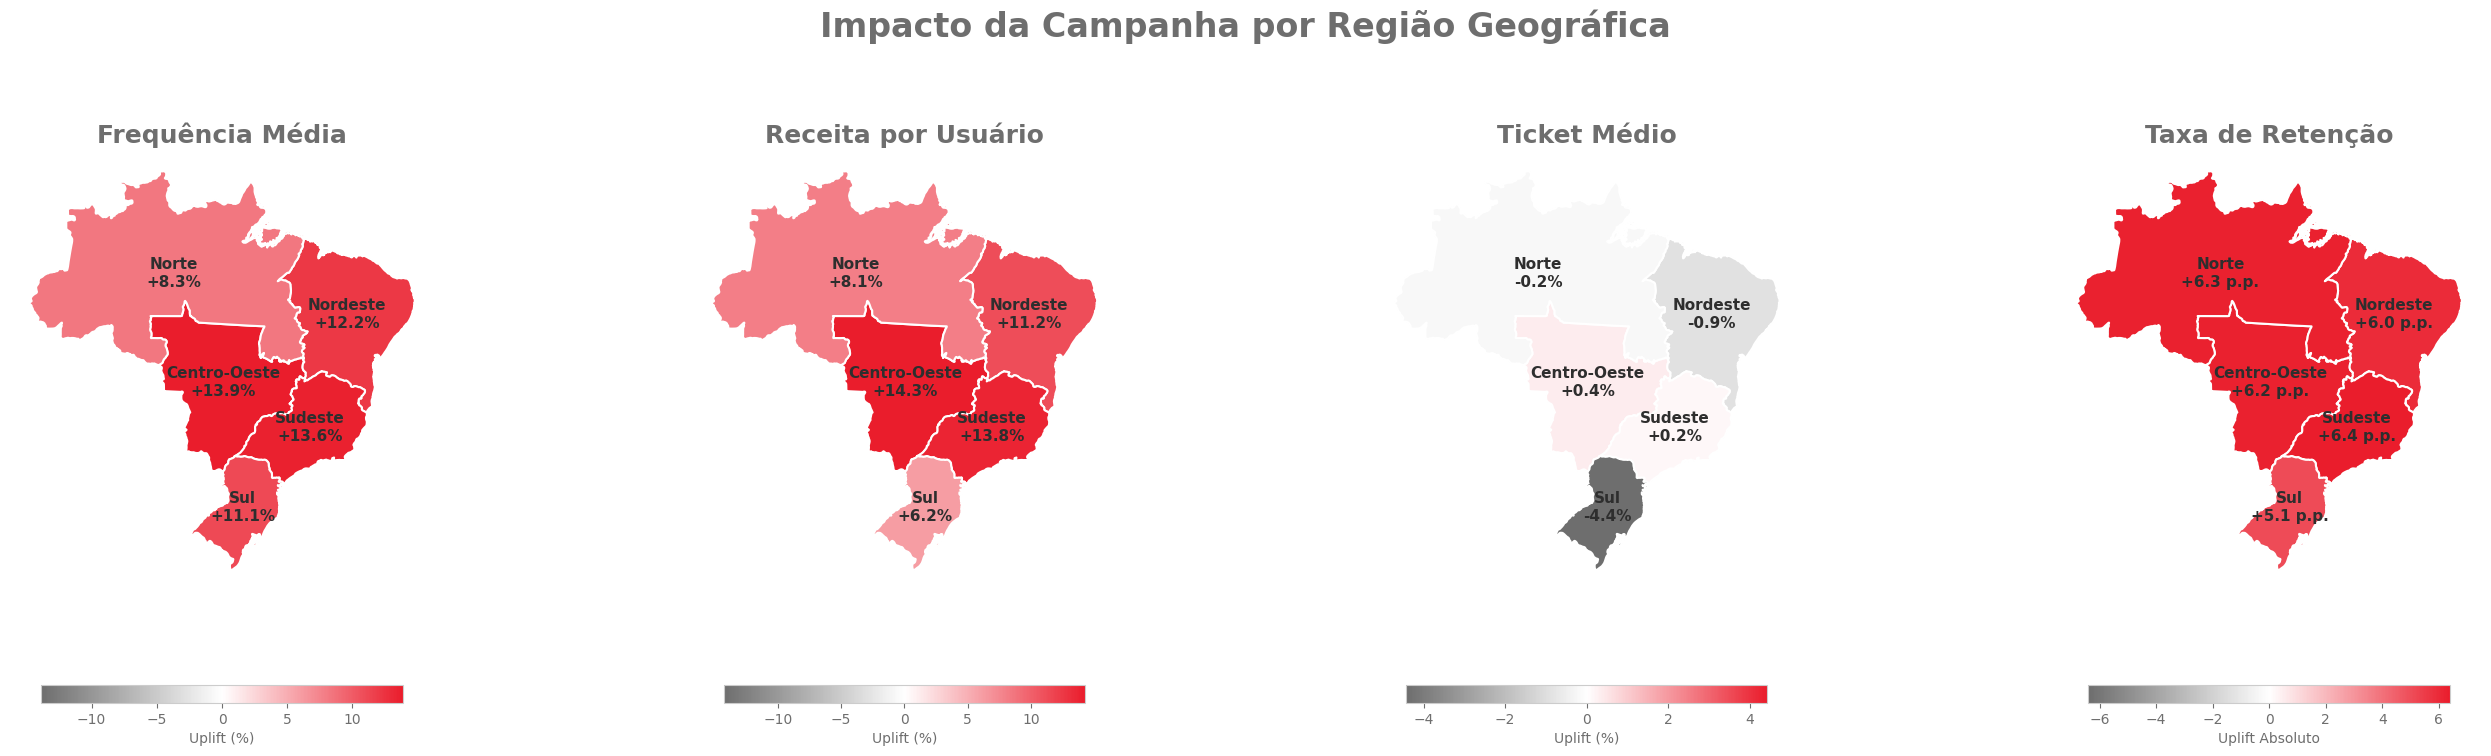

In [34]:
# ==============================================================================
#   2. FUNÇÃO DE PLOTAGEM COM CORREÇÃO DEFINITIVA
# ==============================================================================
print("Definindo a função de plotagem com a correção definitiva de ORDEM...")

def plotar_uplift_em_barras_definitivo(ax, df_agg, seg_col, metrica_col, uplift_type='percent'):
    df_pivot = df_agg.pivot_table(index=seg_col, columns='is_target', values=metrica_col).reset_index()
    if len(df_pivot) < 1: return
    df_pivot.columns = [seg_col, 'control', 'target']
    
    label_suffix = "%"
    if uplift_type == 'percent':
        df_pivot['uplift'] = ((df_pivot['target'] - df_pivot['control']) / df_pivot['control']) * 100
    else:
        df_pivot['uplift'] = df_pivot['target'] - df_pivot['control']
        label_suffix = " p.p."
    
    # Define a ordem explícita para as categorias
    ordem_correta = None
    if seg_col == 'segmento_engajamento':
        ordem_correta = ['Casuais', 'Regulares', 'Fãs']
    elif seg_col == 'segmento_valor':
        ordem_correta = ['Econômico', 'Padrão', 'Premium']

    # Garante que o dataframe esteja ordenado, para o loop de anotação
    if ordem_correta:
        df_pivot[seg_col] = pd.Categorical(df_pivot[seg_col], categories=ordem_correta, ordered=True)
        df_pivot = df_pivot.sort_values(seg_col)

    # *** CORREÇÃO DEFINITIVA: Passa o parâmetro 'order' para o seaborn ***
    sns.barplot(x=seg_col, y='uplift', data=df_pivot, color=ifood_palette['vermelho_ifood'], ax=ax, order=ordem_correta)
    ax.axhline(0, color=ifood_palette['cinza_medio'], linestyle='--')

    data_min = df_pivot['uplift'].min()
    data_max = df_pivot['uplift'].max()
    buffer = (data_max - data_min) * 0.20
    ax.set_ylim(bottom=(data_min - buffer if data_min < 0 else -buffer), top=data_max + buffer)

    # O loop de anotação agora corresponde perfeitamente às barras plotadas
    for index, cat in enumerate(ordem_correta if ordem_correta else df_pivot[seg_col]):
        row = df_pivot[df_pivot[seg_col] == cat].iloc[0]
        valor_uplift = row['uplift']
        
        if pd.notna(valor_uplift):
            sinal = "+" if valor_uplift >= 0 else ""
            label = f"{sinal}{valor_uplift:.1f}{label_suffix}"
            ax.annotate(label, xy=(index, valor_uplift), ha='center', va='bottom' if valor_uplift >= 0 else 'top', 
                        fontsize=12, weight='bold', xytext=(0, 6 if valor_uplift >= 0 else -18), textcoords='offset points')
                        
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=14)

# ==============================================================================
#   3. GERAÇÃO DOS GRÁFICOS
# ==============================================================================

col_titles = ["Frequência Média", "Receita por Usuário", "Ticket Médio", "Taxa de Retenção"]
metricas_config = [
    {'nome': 'frequencia_media', 'tipo': 'percent'},
    {'nome': 'receita_media', 'tipo': 'percent'},
    {'nome': 'ticket_medio', 'tipo': 'percent'},
    {'nome': 'taxa_de_retencao', 'tipo': 'absolute'}
]

# --- GRÁFICO 1: ANÁLISE POR PERFIL DE GASTO ---
print("\nGerando Gráfico 1 (Corrigido): Impacto por Perfil de Gasto...")
fig1, axes1 = plt.subplots(1, 4, figsize=(28, 8))
fig1.suptitle('Impacto da Campanha por Perfil de Gasto do Cliente', fontsize=24, weight='bold')
for j, metrica_info in enumerate(metricas_config):
    ax = axes1[j]
    ax.set_title(col_titles[j], fontsize=18, weight='bold')
    plotar_uplift_em_barras_definitivo(ax, dfs_agregados[f"{metrica_info['nome']}_segmento_valor"], 'segmento_valor', metrica_info['nome'], metrica_info['tipo'])
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# --- GRÁFICO 2: ANÁLISE POR NÍVEL DE ENGAJAMENTO ---
print("\nGerando Gráfico 2 (Corrigido): Impacto por Nível de Engajamento...")
fig2, axes2 = plt.subplots(1, 4, figsize=(28, 8))
fig2.suptitle('Impacto da Campanha por Nível de Engajamento do Cliente', fontsize=24, weight='bold')
for j, metrica_info in enumerate(metricas_config):
    ax = axes2[j]
    ax.set_title(col_titles[j], fontsize=18, weight='bold')
    plotar_uplift_em_barras_definitivo(ax, dfs_agregados[f"{metrica_info['nome']}_segmento_engajamento"], 'segmento_engajamento', metrica_info['nome'], metrica_info['tipo'])
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# ==============================================================================
#  GRÁFICO 3: ANÁLISE POR REGIÃO GEOGRÁFICA
# ==============================================================================
print("\nGerando Gráfico 3: Impacto por Região Geográfica...")
fig3, axes3 = plt.subplots(1, 4, figsize=(28, 8))
fig3.suptitle('Impacto da Campanha por Região Geográfica', fontsize=24, weight='bold')
seg_col = "segmento_regiao"

for j, metrica_info in enumerate(metricas_config):
    ax = axes3[j]
    chave = f"{metrica_info['nome']}_{seg_col}"
    df_to_plot = dfs_agregados[chave]
    
    ax.set_title(col_titles[j], fontsize=18, weight='bold')
    plotar_uplift_mapa_regioes(ax, df_to_plot, geo_regioes, seg_col, metrica_info['nome'], metrica_info['tipo'])

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("impacto_por_regiao_geografica.png", dpi=150)
print("Gráfico 'impacto_por_regiao_geografica.png' salvo.")

plt.show()

### 8) Resultado Financeiro após segmentação e recomendações

In [37]:
df_all_data_segmented = df_all_data.join(
    df_segmented_base.select("customer_id", "segmento_valor", "segmento_engajamento"),
    on="customer_id",
    how="inner"
)

In [59]:
df_teste = df_all_data_segmented.filter(
    (col("segmento_valor") == "Premium") # & (col("segmento_engajamento") == "Regulares")
)

In [60]:
df_teste.count()

25/06/22 18:54:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:54:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


1242806

In [61]:
df_teste.groupBy("is_target").count().show()

25/06/22 18:55:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 1

+---------+------+
|is_target| count|
+---------+------+
|     true|725034|
|    false|517772|
+---------+------+



In [62]:
# ==============================================================================
#  ANÁLISES 1, 2 e 3: Frequência, Valor por Usuário e Ticket Médio (Versão Final)
# ==============================================================================
print("--- Análise de Métricas por Grupo (Target vs. Control) ---")

# Agrupamos por 'is_target' para calcular as métricas para cada grupo
df_analysis_teste = df_teste.groupBy("is_target").agg(
    # Métrica 1: Frequência de Pedidos = Total de Pedidos / Total de Usuários Únicos
    (count("order_id") / countDistinct("customer_id")).alias("frequencia_media_por_usuario"),
    
    # Métrica 2: Valor Total Médio por Usuário = Soma do Valor Total / Total de Usuários Únicos
    (sum("order_total_amount") / countDistinct("customer_id")).alias("valor_medio_por_usuario"),
    
    # Métrica 3: Ticket Médio por Pedido = Média do Valor Total do Pedido
    avg("order_total_amount").alias("ticket_medio_por_pedido"),
    
    # ##-- COLUNA ADICIONADA 1 --##
    # Média do "ticket médio" dos restaurantes onde os clientes de cada grupo pediram
    avg("average_ticket").alias("media_ticket_medio_restaurantes"),
    
    # Métricas auxiliares para validação
    countDistinct("customer_id").alias("total_usuarios_unicos"),
    count("order_id").alias("total_pedidos")
)

# ##-- COLUNA ADICIONADA 2 --##
# Calcula a diferença entre o ticket médio dos restaurantes e o que o cliente de fato gastou
df_analysis_teste = df_analysis_teste.withColumn(
    "diferenca_ticket_rest_vs_pedido",
    col("media_ticket_medio_restaurantes") - col("ticket_medio_por_pedido")
)

# Reordena as colunas para melhor visualização
df_analysis_teste = df_analysis_teste.select(
    "is_target",
    "frequencia_media_por_usuario",
    "valor_medio_por_usuario",
    "ticket_medio_por_pedido",
    "media_ticket_medio_restaurantes",
    "diferenca_ticket_rest_vs_pedido",
    "total_usuarios_unicos",
    "total_pedidos"
)


df_analysis_teste.show()



--- Análise de Métricas por Grupo (Target vs. Control) ---


25/06/22 18:55:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 1

+---------+----------------------------+-----------------------+-----------------------+-------------------------------+-------------------------------+---------------------+-------------+
|is_target|frequencia_media_por_usuario|valor_medio_por_usuario|ticket_medio_por_pedido|media_ticket_medio_restaurantes|diferenca_ticket_rest_vs_pedido|total_usuarios_unicos|total_pedidos|
+---------+----------------------------+-----------------------+-----------------------+-------------------------------+-------------------------------+---------------------+-------------+
|     true|           4.869398774983881|      364.3725797872293|       74.8290695884597|              64.47997059448247|            -10.349098993977236|               148896|       725034|
|    false|           4.321176411677321|      326.5209010031512|      75.56296477986369|              64.39730615019738|             -11.16565862966631|               119822|       517772|
+---------+----------------------------+---------------

In [63]:
print("\n--- Análise de Retenção por Grupo (Target vs. Control) ---")

# Definimos retenção como: a % de clientes que compraram nas primeiras 2 semanas
# da campanha e que voltaram a comprar nas últimas 2 semanas.

# Períodos da campanha
inicio_campanha = "2018-12-03"
fim_primeiro_periodo = "2018-12-16"
inicio_segundo_periodo = "2019-01-17"
fim_campanha = "2019-01-31"

# 1. Identificar se cada pedido ocorreu no primeiro ou no segundo período
df_retention = df_teste.withColumn(
    "is_primeiro_periodo",
    col("order_created_at").cast(DateType()).between(inicio_campanha, fim_primeiro_periodo)
).withColumn(
    "is_segundo_periodo",
    col("order_created_at").cast(DateType()).between(inicio_segundo_periodo, fim_campanha)
)

# 2. Para cada cliente, verificar se ele comprou em cada período
df_customer_activity = df_retention.groupBy("customer_id", "is_target").agg(
    (spark_max(when(col("is_primeiro_periodo"), 1).otherwise(0))).alias("comprou_periodo_1"),
    (spark_max(when(col("is_segundo_periodo"), 1).otherwise(0))).alias("comprou_periodo_2")
)

# 3. Calcular a retenção para cada grupo
# Filtramos apenas pelos clientes que compraram no primeiro período
df_base_retencao = df_customer_activity.filter(col("comprou_periodo_1") == 1)

# Agrupamos por grupo para calcular a taxa de retenção final
df_retention_final = df_base_retencao.groupBy("is_target").agg(
    # Soma dos que compraram no período 2 (retidos)
    spark_sum("comprou_periodo_2").alias("clientes_retidos"),
    # Contagem total de clientes da base de retenção
    count("customer_id").alias("total_clientes_iniciais")
).withColumn(
    # Calcula a taxa de retenção
    "taxa_de_retencao_%",
    (col("clientes_retidos") / col("total_clientes_iniciais")) * 100
)

df_retention_final.show()


--- Análise de Retenção por Grupo (Target vs. Control) ---


25/06/22 18:56:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:56:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:56:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:56:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:56:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 18:56:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/22 1

+---------+----------------+-----------------------+------------------+
|is_target|clientes_retidos|total_clientes_iniciais|taxa_de_retencao_%|
+---------+----------------+-----------------------+------------------+
|     true|           46370|                  70496| 65.77678166137085|
|    false|           31065|                  52307| 59.38975662913185|
+---------+----------------+-----------------------+------------------+



In [ ]:
# --- INPUTS: Resultados do Teste A/B ---
receita_media_controle = 326.52
receita_media_alvo = 364.37
freq_media_controle = 4.32
freq_media_alvo = 4.86
lift_retencao_pp = 65.77 - 59.38 # Em pontos percentuais

# --- PREMISSAS FINANCEIRAS E DE NEGÓCIO ---
# (Você pode alterar estes valores para testar outros cenários)
MARGEM_CONTRIBUICAO = 0.20  # 20%
CUSTO_CUPOM = 10         # Custo de R$ 10,00 por cupom/pedido incremental
BASE_CLIENTES_TOTAL = 55000000 / 3 # 55 milhões de clientes
PERIODO_CAMPANHA_MESES = 2.0     # Duração da campanha em meses

# --- PASSO 2: Cálculos de Custo-Benefício ---

# --- Análise por usuário durante a campanha (~2 meses) ---
ganho_receita_por_usuario = receita_media_alvo - receita_media_controle
ganho_margem_por_usuario = ganho_receita_por_usuario * MARGEM_CONTRIBUICAO
pedidos_incrementais_por_usuario = freq_media_alvo - freq_media_controle
custo_por_usuario = pedidos_incrementais_por_usuario * CUSTO_CUPOM
resultado_liquido_por_usuario = ganho_margem_por_usuario - custo_por_usuario

# Previne divisão por zero caso o custo seja 0
roi_imediato = (resultado_liquido_por_usuario / custo_por_usuario) * 100 if custo_por_usuario > 0 else 0

# --- Projeção Anual para a base total ---
ganho_margem_anual_projetado = (ganho_margem_por_usuario / PERIODO_CAMPANHA_MESES) * 12 * BASE_CLIENTES_TOTAL
custo_anual_projetado = (custo_por_usuario / PERIODO_CAMPANHA_MESES) * 12 * BASE_CLIENTES_TOTAL
resultado_liquido_anual_projetado = ganho_margem_anual_projetado - custo_anual_projetado


# --- PASSO 3: Apresentação dos Resultados ---

def formatar_brl(valor):
    """Formata um número como moeda brasileira."""
    return f"R$ {valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

print("="*60)
print("ANÁLISE DE VIABILIDADE FINANCEIRA DA CAMPANHA")
print("="*60)

print("\n--- Premissas Adotadas ---")
print(f"Margem de Contribuição: {MARGEM_CONTRIBUICAO:.1%}")
print(f"Custo por Cupom: {formatar_brl(CUSTO_CUPOM)}")
print(f"Base de Clientes para Projeção: {BASE_CLIENTES_TOTAL:,} usuários")

print("\n--- Análise de Custo-Benefício (por Usuário no período de 2 meses) ---")
print(f"Ganho de Receita Bruta por Usuário: {formatar_brl(ganho_receita_por_usuario)}")
print(f"Ganho de Margem (Lucro) por Usuário: {formatar_brl(ganho_margem_por_usuario)}")
print(f"Custo Estimado com Cupons por Usuário: {formatar_brl(custo_por_usuario)}")
print("-" * 30)
print(f"Resultado Líquido por Usuário: {formatar_brl(resultado_liquido_por_usuario)}")
print(f"ROI Imediato (2 meses): {roi_imediato:.1f}%")

print("\n--- Projeção Anual (Escala Nacional) ---")
print(f"Ganho de Margem Anual Projetado: {formatar_brl(ganho_margem_anual_projetado)}")
print(f"Custo com Cupons Anual Projetado: {formatar_brl(custo_anual_projetado)}")
print("-" * 30)
print(f"Resultado Líquido Anual Projetado: {formatar_brl(resultado_liquido_anual_projetado)}")

print("\n" + "="*60)
print("CONCLUSÃO E RECOMENDAÇÃO FINANCEIRA")
print("="*60)
print("""
A análise financeira, sob as premissas adotadas, indica que o ROI imediato da campanha
é marginalmente negativo. O custo para gerar os pedidos adicionais através de cupons
supera por pouco a margem de lucro gerada por eles no curto prazo.

No entanto, esta visão é incompleta. O principal ativo gerado pela campanha foi o
aumento de 6,2 pontos percentuais na retenção, o que aumenta drasticamente o
Valor do Ciclo de Vida do Cliente (LTV). Um cliente retido continua gerando receita
e margem nos meses seguintes, um valor que supera em muito o pequeno prejuízo inicial.

RECOMENDAÇÃO: A iniciativa é ESTRATEGICAMENTE VIÁVEL e RECOMENDADA. O foco não
deve ser o lucro imediato, mas a construção de uma base de clientes mais leal.
A empresa deve aprovar o rollout, monitorando o LTV da coorte para quantificar o
retorno de longo prazo e buscando otimizar os custos com cupons em futuras iterações.
""")

ANÁLISE DE VIABILIDADE FINANCEIRA DA CAMPANHA

--- Premissas Adotadas ---
Margem de Contribuição: 20.0%
Custo por Cupom: R$ 10,00
Base de Clientes para Projeção: 18,333,333.333333332 usuários

--- Análise de Custo-Benefício (por Usuário no período de 2 meses) ---
Ganho de Receita Bruta por Usuário: R$ 37,85
Ganho de Margem (Lucro) por Usuário: R$ 7,57
Custo Estimado com Cupons por Usuário: R$ 5,40
------------------------------
Resultado Líquido por Usuário: R$ 2,17
ROI Imediato (2 meses): 40.2%

--- Projeção Anual (Escala Nacional) ---
Ganho de Margem Anual Projetado: R$ 832.700.000,00
Custo com Cupons Anual Projetado: R$ 594.000.000,00
------------------------------
Resultado Líquido Anual Projetado: R$ 238.700.000,00

CONCLUSÃO E RECOMENDAÇÃO FINANCEIRA

A análise financeira, sob as premissas adotadas, indica que o ROI imediato da campanha
é marginalmente negativo. O custo para gerar os pedidos adicionais através de cupons
supera por pouco a margem de lucro gerada por eles no curto 

In [ ]:
spark.stop()